<a href="https://colab.research.google.com/github/colarrbear/DA-opinion_analytics/blob/main/DA-opinion_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aspect-Based Sentiment Analysis (ABSA) for Sephora Product Reviews

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt_tab')
from sklearn.decomposition import LatentDirichletAllocation
import string

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/maysahs/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [63]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/maysahs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maysahs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/maysahs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [64]:
# Load product info dataset
product_df = pd.read_csv('datasets/product_info.csv')
product_df.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,variation_desc,ingredients,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,NaN,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",35.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [65]:
# Load review datasets and concatenate
review_files = [
    'datasets/reviews_0-250.csv',
    'datasets/reviews_250-500.csv',
    'datasets/reviews_500-750.csv',
    'datasets/reviews_750-1250.csv',
    'datasets/reviews_1250-end.csv'
]

reviews_list = []
for file in review_files:
    df = pd.read_csv(file)
    reviews_list.append(df)
    
if not reviews_list:
    raise ValueError("No review data was loaded. Please check file paths.")

reviews = pd.concat(reviews_list, ignore_index=True)

## Data Loading and Exploration

In [66]:
# Basic exploration
print(f"Product info shape: {product_df.shape}")
print(f"Reviews shape: {reviews.shape}")

Product info shape: (8494, 27)
Reviews shape: (1094411, 19)


In [67]:
# Display the first few rows of each dataset
product_df.head()
reviews.head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [68]:
# Check for missing values
print("Missing values in product_info:")
product_df.isnull().sum()

Missing values in product_info:


product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
variation_type        1444
variation_value       1598
variation_desc        7244
ingredients            945
price_usd                0
value_price_usd       8043
sale_price_usd        8224
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
child_max_price       5740
child_min_price       5740
dtype: int64

In [69]:
print("\nMissing values in reviews:")
reviews.isnull().sum()


Missing values in reviews:


Unnamed: 0                       0
author_id                        0
rating                           0
is_recommended              167988
helpfulness                 561592
total_feedback_count             0
total_neg_feedback_count         0
total_pos_feedback_count         0
submission_time                  0
review_text                   1444
review_title                310654
skin_tone                   170539
eye_color                   209628
skin_type                   111557
hair_color                  226768
product_id                       0
product_name                     0
brand_name                       0
price_usd                        0
dtype: int64

In [70]:
# Basic statistics
print("\nBasic statistics for numerical columns in product_info:")
product_df.describe()


Basic statistics for numerical columns in product_info:


,brand_id,loves_count,rating,reviews,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,child_count,child_max_price,child_min_price
count,8494.000000,8.494000e+03,8216.000000,8216.000000,8494.000000,451.000000,270.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,2754.000000,2754.000000
mean,5422.440546,2.917957e+04,4.194513,448.545521,51.655595,91.168537,20.207889,0.070285,0.071698,0.219096,0.073699,0.279374,1.631622,53.792023,39.665802
std,1709.595957,6.609212e+04,0.516694,1101.982529,53.669234,79.195631,24.327352,0.255642,0.258002,0.413658,0.261296,0.448718,5.379470,58.765894,38.685720
min,1063.000000,0.000000e+00,1.000000,1.000000,3.000000,0.000000,1.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
25%,5333.000000,3.758000e+03,3.981725,26.000000,25.000000,45.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,19.000000
50%,6157.500000,9.880000e+03,4.289350,122.000000,35.000000,67.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,28.000000
75%,6328.000000,2.684125e+04,4.530525,418.000000,58.000000,108.500000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,59.000000,42.000000
max,8020.000000,1.401068e+06,5.000000,21281.000000,1900.000000,617.000000,320.000000,1.000000,1.000000,1.000000,1.000000,1.000000,105.000000,570.000000,400.000000


In [71]:
print("\nBasic statistics for numerical columns in reviews:")
reviews.describe()


Basic statistics for numerical columns in reviews:


,Unnamed: 0,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,price_usd
count,1.094411e+06,1.094411e+06,926423.000000,532819.000000,1.094411e+06,1.094411e+06,1.094411e+06,1.094411e+06
mean,1.989864e+05,4.299158e+00,0.839962,0.767782,4.177126e+00,8.948695e-01,3.282257e+00,4.900838e+01
std,1.749886e+05,1.149444e+00,0.366642,0.317164,2.271524e+01,5.288943e+00,1.967482e+01,4.004338e+01
min,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,5.590600e+04,4.000000e+00,1.000000,0.652174,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01
50%,1.308240e+05,5.000000e+00,1.000000,0.928571,0.000000e+00,0.000000e+00,0.000000e+00,3.900000e+01
75%,3.285265e+05,5.000000e+00,1.000000,1.000000,3.000000e+00,1.000000e+00,3.000000e+00,6.200000e+01
max,6.021290e+05,5.000000e+00,1.000000,1.000000,5.464000e+03,1.159000e+03,5.050000e+03,1.900000e+03


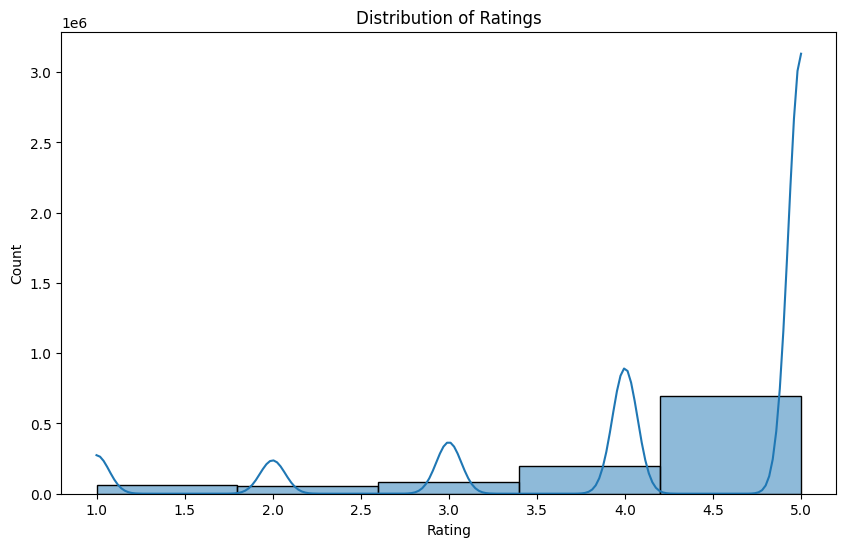

In [72]:
# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(reviews['rating'], bins=5, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

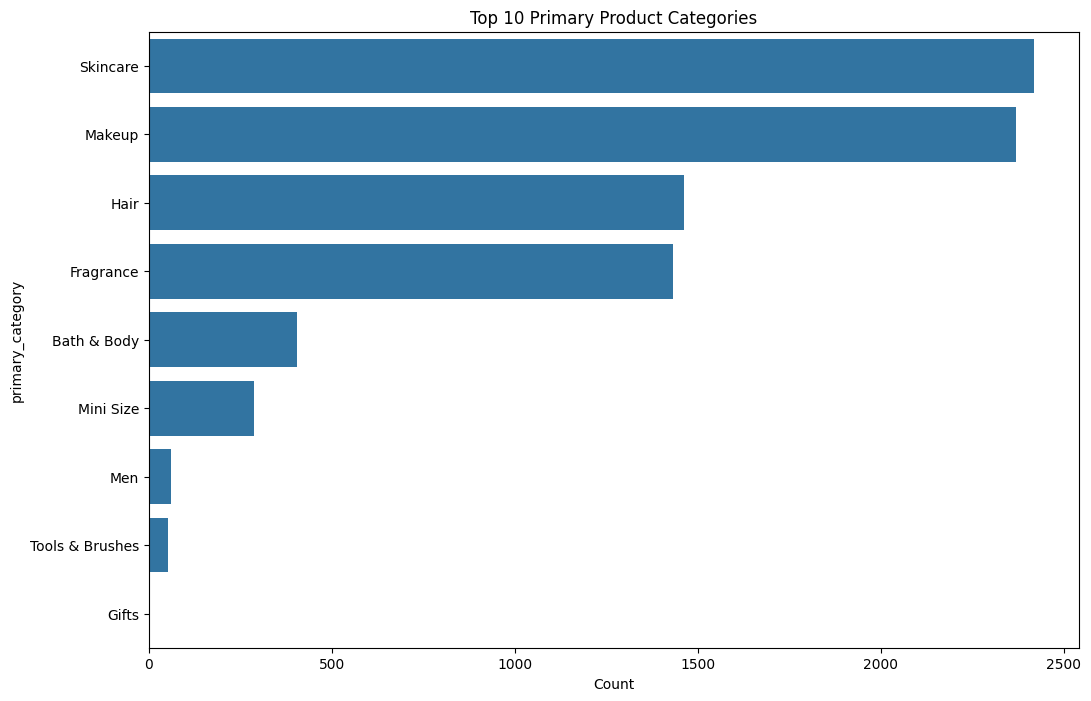

In [73]:
# Distribution of product categories
plt.figure(figsize=(12, 8))
primary_categories = product_df['primary_category'].value_counts().head(10)
sns.barplot(x=primary_categories.values, y=primary_categories.index)
plt.title('Top 10 Primary Product Categories')
plt.xlabel('Count')
plt.show()

## Data Preprocessing and Cleaning

In [74]:
# Merge product information with reviews on product_id
merged_data = pd.merge(reviews, product_df, on=['product_id', 'product_name', 'brand_name', 'price_usd'], how='inner')

# Check shape after merging
print(f"Merged data shape: {merged_data.shape}")

Merged data shape: (1094411, 42)


In [75]:
# Create a function to clean review text
def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Clean review text
merged_data['clean_review_text'] = merged_data['review_text'].apply(clean_text)
merged_data['clean_review_title'] = merged_data['review_title'].apply(clean_text)

# Tokenize and remove stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    if pd.isna(text) or text == "":
        return []
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    
    return tokens

merged_data['tokens'] = merged_data['clean_review_text'].apply(tokenize_and_lemmatize)

# Create a column with joined tokens for further analysis
merged_data['processed_text'] = merged_data['tokens'].apply(lambda x: ' '.join(x))

# Check the results
merged_data[['review_text', 'clean_review_text', 'processed_text']].head()

,review_text,clean_review_text,processed_text
0,I use this with the Nudestix “Citrus Clean Bal...,i use this with the nudestix “citrus clean bal...,use nudestix citrus clean balm makeup melt dou...
1,I bought this lip mask after reading the revie...,i bought this lip mask after reading the revie...,bought lip mask reading review hype unfortunat...
2,My review title says it all! I get so excited ...,my review title says it all i get so excited t...,review title say get excited get bed apply lip...
3,I’ve always loved this formula for a long time...,i’ve always loved this formula for a long time...,always loved formula long time honestly even u...
4,"If you have dry cracked lips, this is a must h...",if you have dry cracked lips this is a must ha...,dry cracked lip must week use learned always b...


In [76]:
# Display all column names
print(repr(merged_data.columns.tolist()))  

['Unnamed: 0', 'author_id', 'rating_x', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd', 'brand_id', 'loves_count', 'rating_y', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price', 'clean_review_text', 'clean_review_title', 'tokens', 'processed_text']


## Data Transformation and Feature Engineering

In [77]:
# Create sentiment score based on rating
merged_data['sentiment_score'] = merged_data['rating_x'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')

# Convert categorical features to one-hot encoding
categorical_cols = ['primary_category', 'secondary_category', 'tertiary_category', 'skin_type', 'eye_color', 'skin_tone', 'hair_color']

for col in categorical_cols:
    if col in merged_data.columns:
        # Fill NaN values with 'unknown'
        merged_data[col] = merged_data[col].fillna('unknown')
        
        # Create one-hot encoding
        one_hot = pd.get_dummies(merged_data[col], prefix=col)
        
        # Join the encoded df
        merged_data = merged_data.join(one_hot)

# Extract year and month from submission_time for temporal analysis
merged_data['submission_time'] = pd.to_datetime(merged_data['submission_time'])
merged_data['review_year'] = merged_data['submission_time'].dt.year
merged_data['review_month'] = merged_data['submission_time'].dt.month

# Create a feature for review length
merged_data['review_length'] = merged_data['review_text'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Create TF-IDF features for review text
tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=5)
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_data['processed_text'].fillna(''))

# Convert TF-IDF matrix to dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the shape of TF-IDF dataframe
print(f"TF-IDF matrix shape: {tfidf_df.shape}")

TF-IDF matrix shape: (1094411, 1000)


## Aspect Extraction

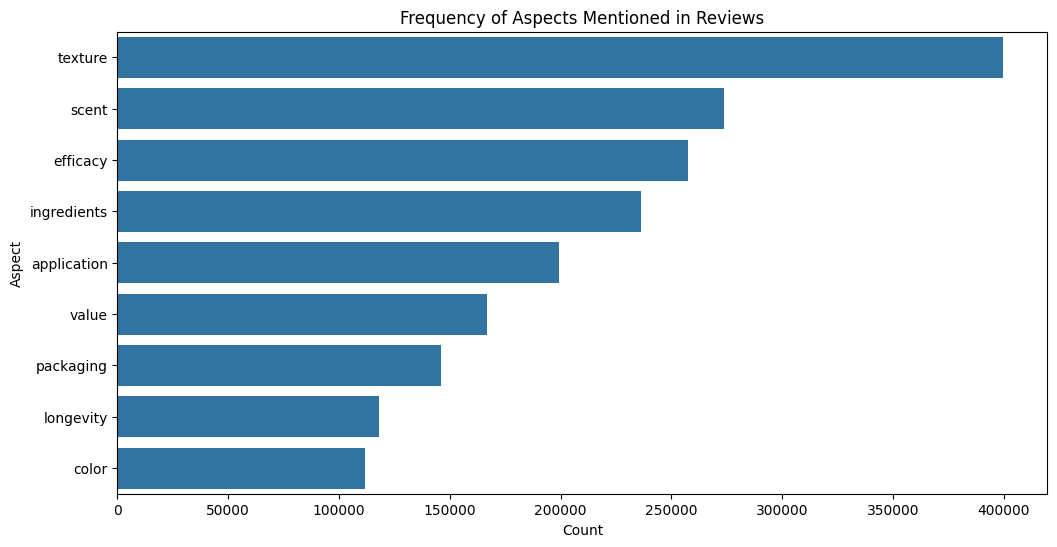

In [78]:
# Define common aspects to look for in beauty product reviews
beauty_aspects = {
    'packaging': ['packaging', 'container', 'bottle', 'jar', 'tube', 'pump', 'applicator'],
    'texture': ['texture', 'consistency', 'creamy', 'lightweight', 'heavy', 'sticky', 'oily', 'watery', 'silky', 'smooth'],
    'scent': ['scent', 'fragrance', 'smell', 'odor', 'aroma', 'perfume'],
    'efficacy': ['works', 'effective', 'result', 'results', 'difference', 'effective', 'ineffective', 'improvement'],
    'ingredients': ['ingredient', 'ingredients', 'natural', 'chemical', 'organic', 'paraben', 'sulfate', 'alcohol', 'oil'],
    'longevity': ['last', 'lasting', 'longevity', 'wear', 'duration', 'long-lasting', 'short-lived', 'wears off'],
    'value': ['price', 'expensive', 'affordable', 'worth', 'value', 'cost', 'pricey', 'cheap', 'investment', 'bargain'],
    'application': ['apply', 'application', 'absorb', 'absorption', 'blend', 'blending', 'spreads', 'rub'],
    'color': ['color', 'pigment', 'shade', 'tint', 'tone', 'hue', 'pigmentation', 'vibrant', 'dull']
}

# Function to identify aspects in a review
def extract_aspects(text, aspect_dict):
    if pd.isna(text) or text == "":
        return {}
    
    text_lower = text.lower()
    found_aspects = {}
    
    for aspect, keywords in aspect_dict.items():
        for keyword in keywords:
            if keyword in text_lower:
                if aspect not in found_aspects:
                    found_aspects[aspect] = []
                found_aspects[aspect].append(keyword)
    
    return found_aspects

# Apply aspect extraction to each review
merged_data['aspects'] = merged_data['clean_review_text'].apply(lambda x: extract_aspects(x, beauty_aspects))

# Create binary flags for each aspect
for aspect in beauty_aspects.keys():
    merged_data[f'has_{aspect}'] = merged_data['aspects'].apply(lambda x: 1 if aspect in x else 0)

# Calculate the count of each aspect
aspect_counts = merged_data[[f'has_{aspect}' for aspect in beauty_aspects.keys()]].sum().reset_index()
aspect_counts.columns = ['aspect', 'count']
aspect_counts['aspect'] = aspect_counts['aspect'].apply(lambda x: x.replace('has_', ''))

# Visualize aspect counts
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='aspect', data=aspect_counts.sort_values('count', ascending=False))
plt.title('Frequency of Aspects Mentioned in Reviews')
plt.xlabel('Count')
plt.ylabel('Aspect')
plt.show()

## Sentiment Analysis by Aspect

--- Calculating Review-Level VADER Scores ---
Calculating VADER scores for each review (using clean_review_text)...
VADER scores calculated.
Extracting scores into columns (neg_score, neu_score, pos_score, compound_score)...
'compound_score' column added to merged_data.
Verification successful: 'compound_score' is in merged_data.columns
NaNs in compound_score: 0
--------------------------------------------------
--- Starting Sentence-Level Aspect Sentiment Analysis ---
Processed 10000 reviews for sentence analysis...
Processed 20000 reviews for sentence analysis...
Processed 30000 reviews for sentence analysis...
Processed 40000 reviews for sentence analysis...
Processed 50000 reviews for sentence analysis...
Processed 60000 reviews for sentence analysis...
Processed 70000 reviews for sentence analysis...
Processed 80000 reviews for sentence analysis...
Processed 90000 reviews for sentence analysis...
Processed 100000 reviews for sentence analysis...
Processed 110000 reviews for senten

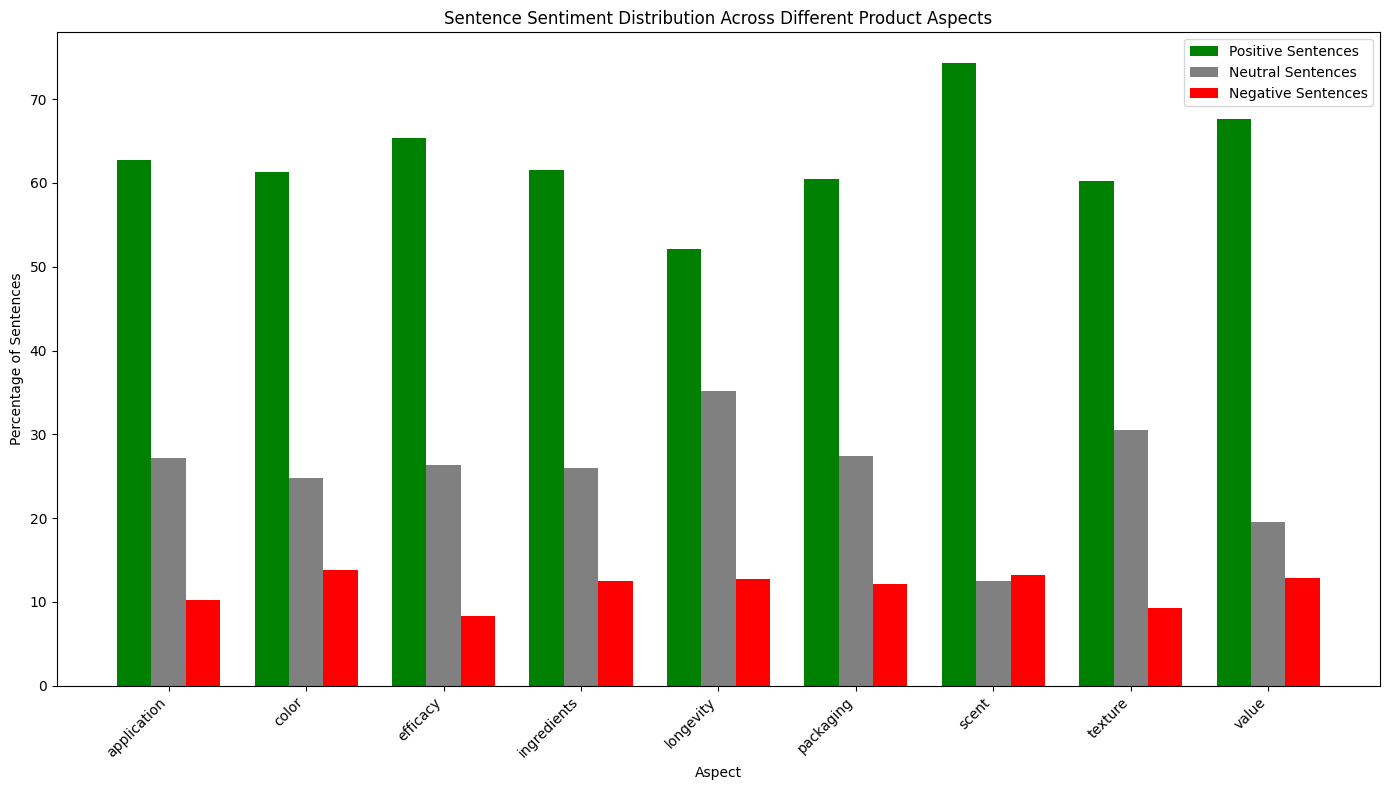


--- Visualizing Average Sentence Sentiment Score ---


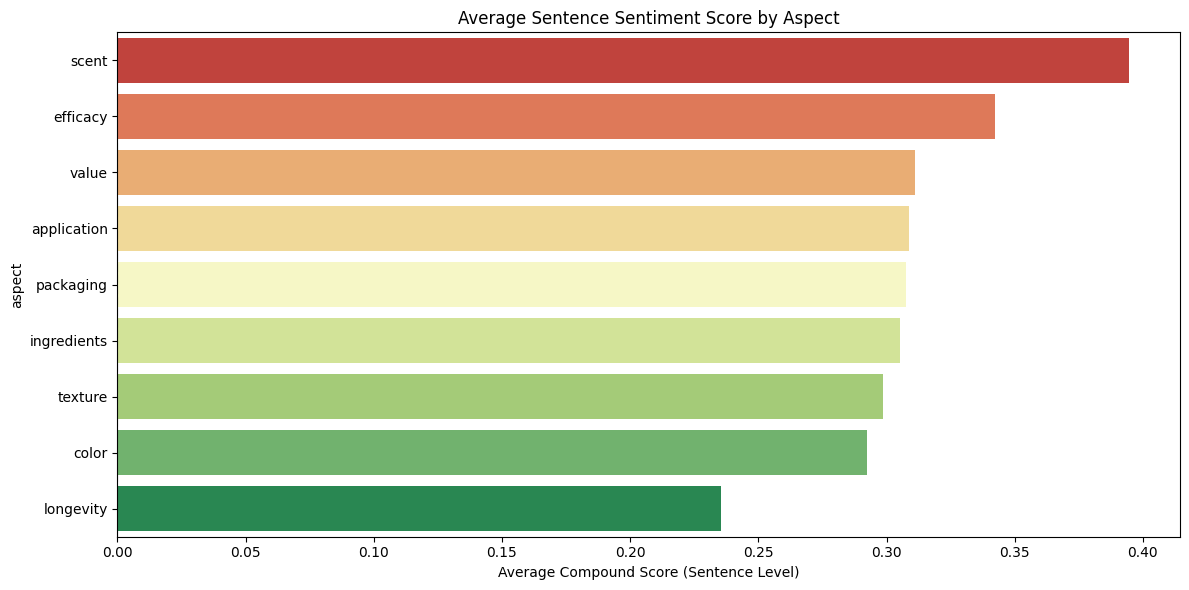

In [79]:
# --- Step 1: Calculate Review-Level VADER Scores (Needed by many sections) ---

print("--- Calculating Review-Level VADER Scores ---")
# Download VADER lexicon and sentence tokenizer if needed
try:
    nltk.data.find("sentiment/vader_lexicon.zip")
except LookupError:
    nltk.download("vader_lexicon")
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Function to get sentiment scores for text (used for both review and sentence level)
def get_sentiment_scores(text):
    if pd.isna(text) or text == "":
        return {"neg": 0, "neu": 0, "pos": 0, "compound": 0}
    # Limit text length for VADER if necessary (optional, VADER handles long text but can be slow)
    # max_len = 3000
    # if len(text) > max_len:
    #     text = text[:max_len]
    return sid.polarity_scores(text)

# Apply sentiment analysis to the CLEANED review text
print("Calculating VADER scores for each review (using clean_review_text)...")
if 'clean_review_text' not in merged_data.columns:
     raise ValueError("Column 'clean_review_text' not found. Ensure preprocessing is complete.")

# It's generally better to apply VADER to text with punctuation, but clean_review_text is often used
# If clean_review_text removed too much, consider applying to 'review_text' but handle potential errors
merged_data['sentiment_scores'] = merged_data['clean_review_text'].apply(get_sentiment_scores)
print("VADER scores calculated.")

# Extract sentiment scores into separate columns in merged_data
print("Extracting scores into columns (neg_score, neu_score, pos_score, compound_score)...")
merged_data['neg_score'] = merged_data['sentiment_scores'].apply(lambda x: x.get('neg', 0))
merged_data['neu_score'] = merged_data['sentiment_scores'].apply(lambda x: x.get('neu', 0))
merged_data['pos_score'] = merged_data['sentiment_scores'].apply(lambda x: x.get('pos', 0))
merged_data['compound_score'] = merged_data['sentiment_scores'].apply(lambda x: x.get('compound', 0)) # CRITICAL LINE
print("'compound_score' column added to merged_data.")

# Verify column exists
if 'compound_score' in merged_data.columns:
    print("Verification successful: 'compound_score' is in merged_data.columns")
    print(f"NaNs in compound_score: {merged_data['compound_score'].isnull().sum()}")
else:
    print("Verification FAILED: 'compound_score' is NOT in merged_data.columns")

print("-" * 50)


# --- Step 2: Perform Sentence-Level Aspect Sentiment Analysis (Improved Granularity) ---

print("--- Starting Sentence-Level Aspect Sentiment Analysis ---")

def analyze_aspect_sentiment_sentence_level(data, aspect_dict):
    """
    Analyzes sentiment for aspects at the sentence level.
    Uses 'review_text' for sentence tokenization and sentiment scoring.
    Uses 'clean_review_text' for keyword matching.
    """
    sentence_aspect_sentiments = []
    processed_reviews = 0

    for index, row in data.iterrows():
        original_text = row["review_text"]
        clean_text_for_match = row["clean_review_text"] # Use clean text just for matching

        if pd.isna(original_text) or not original_text:
            continue
        # No need to check clean_text_for_match for NaN if original_text is valid

        try:
            # Tokenize ORIGINAL text to preserve punctuation for VADER
            sentences = sent_tokenize(original_text)
        except Exception as e:
            # print(f"Warning: Error tokenizing review {index}: {e}. Using full text.")
            sentences = [original_text] # Fallback

        # We need a way to match keywords in the cleaned text space
        # Option 1: Tokenize clean text too (as before, risk of mismatch)
        # Option 2: Clean each sentence individually for matching (safer but slower)

        # Using Option 2 here for better robustness:
        for sentence in sentences:
            # Clean the current sentence specifically for keyword matching
            current_clean_sentence_for_match = clean_text(sentence) # Apply your clean_text function

            sentence_aspects_found = set() # Track aspects found in this sentence
            for aspect, keywords in aspect_dict.items():
                # Check the cleaned sentence for the keyword
                if any(keyword in current_clean_sentence_for_match for keyword in keywords):
                    sentence_aspects_found.add(aspect)

            if sentence_aspects_found:
                # Calculate sentiment for the ORIGINAL sentence (with punctuation)
                sentence_sentiment = get_sentiment_scores(sentence)
                for aspect in sentence_aspects_found:
                    sentence_aspect_sentiments.append(
                        {
                            "review_id": index, # Or use actual review ID if available
                            "aspect": aspect,
                            "sentence": sentence, # Store original sentence
                            "compound": sentence_sentiment["compound"],
                            "neg": sentence_sentiment["neg"],
                            "neu": sentence_sentiment["neu"],
                            "pos": sentence_sentiment["pos"],
                        }
                    )
        processed_reviews += 1
        if processed_reviews % 10000 == 0:
            print(f"Processed {processed_reviews} reviews for sentence analysis...")

    print(f"Finished processing {processed_reviews} reviews for sentence analysis.")
    if not sentence_aspect_sentiments:
        print("Warning: No aspects found in any sentences during sentence-level analysis.")
        return pd.DataFrame()

    # Convert list to DataFrame
    sentence_df = pd.DataFrame(sentence_aspect_sentiments)

    # Aggregate results by aspect
    aspect_sentiment_agg = sentence_df.groupby("aspect").agg(
        avg_compound=("compound", "mean"),
        sentence_count=("sentence", "count"),
        positive_sentences=("compound", lambda x: (x > 0.05).sum()),
        neutral_sentences=("compound", lambda x: ((x >= -0.05) & (x <= 0.05)).sum()),
        negative_sentences=("compound", lambda x: (x < -0.05).sum()),
    ).reset_index() # Add reset_index here

    # Calculate percentages
    total_sentences = (
        aspect_sentiment_agg["positive_sentences"] +
        aspect_sentiment_agg["neutral_sentences"] +
        aspect_sentiment_agg["negative_sentences"]
    )
    # Avoid division by zero if total_sentences is 0
    aspect_sentiment_agg["positive_pct"] = np.where(
        total_sentences > 0,
        (aspect_sentiment_agg["positive_sentences"] / total_sentences * 100),
        0
    )
    aspect_sentiment_agg["neutral_pct"] = np.where(
        total_sentences > 0,
        (aspect_sentiment_agg["neutral_sentences"] / total_sentences * 100),
        0
    )
    aspect_sentiment_agg["negative_pct"] = np.where(
        total_sentences > 0,
        (aspect_sentiment_agg["negative_sentences"] / total_sentences * 100),
        0
    )

    return aspect_sentiment_agg # Return the aggregated DataFrame


# --- Apply the sentence-level function ---
aspect_sentiment_df_sentence = analyze_aspect_sentiment_sentence_level(
    merged_data, beauty_aspects
)
print("Sentence-level analysis complete.")
print("Aggregated Sentence-Level Sentiment Head:")
print(aspect_sentiment_df_sentence.head())


# --- Visualize the sentence-level results ---
if not aspect_sentiment_df_sentence.empty:
    print("\n--- Visualizing Sentence-Level Sentiment Distribution ---")
    plt.figure(figsize=(14, 8))
    # Ensure columns exist before plotting
    plot_cols = ['aspect', 'positive_pct', 'neutral_pct', 'negative_pct']
    if all(col in aspect_sentiment_df_sentence.columns for col in plot_cols):
        x = aspect_sentiment_df_sentence["aspect"]
        y1 = aspect_sentiment_df_sentence["positive_pct"]
        y2 = aspect_sentiment_df_sentence["neutral_pct"]
        y3 = aspect_sentiment_df_sentence["negative_pct"]

        width = 0.25
        x_pos = np.arange(len(x))

        plt.bar(x_pos - width, y1, width=width, color="green", label="Positive Sentences")
        plt.bar(x_pos, y2, width=width, color="gray", label="Neutral Sentences")
        plt.bar(x_pos + width, y3, width=width, color="red", label="Negative Sentences")

        plt.xlabel("Aspect")
        plt.ylabel("Percentage of Sentences")
        plt.title("Sentence Sentiment Distribution Across Different Product Aspects")
        plt.xticks(x_pos, x, rotation=45, ha="right")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Could not plot sentence distribution: Missing required columns.")

    # Optional: Visualize average compound score per aspect (sentence-based)
    print("\n--- Visualizing Average Sentence Sentiment Score ---")
    plt.figure(figsize=(12, 6))
    if 'avg_compound' in aspect_sentiment_df_sentence.columns and 'aspect' in aspect_sentiment_df_sentence.columns:
        sns.barplot(
            x="avg_compound",
            y="aspect",
            data=aspect_sentiment_df_sentence.sort_values("avg_compound", ascending=False),
            palette="RdYlGn",
        )
        plt.title("Average Sentence Sentiment Score by Aspect")
        plt.xlabel("Average Compound Score (Sentence Level)")
        plt.axvline(x=0, color="grey", linestyle="--")
        plt.tight_layout()
        plt.show()
    else:
         print("Could not plot average sentence score: Missing required columns.")

else:
    print("No aspect sentiment data from sentence-level analysis to visualize.")



## Advanced ABSA with Machine Learning

In [80]:
# (Requires sentence tokenization and aspect extraction to be done first)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from nltk.tokenize import sent_tokenize # Make sure it's imported

# --- Function with added check ---
def create_aspect_sentence_dataset(data, aspect):
    """Creates dataset using only sentences containing the aspect."""

    # --- ADD CHECK HERE ---
    required_cols = ['review_text', 'clean_review_text', 'compound_score', f'has_{aspect}']
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        raise ValueError(f"The input DataFrame 'data' is missing required columns: {missing_cols}. "
                         "Please ensure preprocessing and VADER sentiment analysis are complete.")
    # --- END CHECK ---

    # Filter to reviews mentioning this aspect
    aspect_reviews = data[data[f'has_{aspect}'] == 1].copy()

    if aspect_reviews.shape[0] < 50: # Initial check based on reviews mentioning aspect
        # print(f"Skipping aspect '{aspect}': Less than 50 reviews mention it.")
        return None, None # Return None for both X and y

    sentences_with_aspect = []
    review_indices = [] # Keep track of original review index for sentiment label

    # Define keywords for the specific aspect
    aspect_keywords = beauty_aspects.get(aspect, [])
    if not aspect_keywords:
        print(f"Warning: No keywords defined for aspect '{aspect}'.")
        return None, None

    for index, row in aspect_reviews.iterrows():
        text = row["review_text"] # Use original for sentence tokenization
        # clean_text_full = row["clean_review_text"] # Use clean for processing later

        if pd.isna(text): continue

        try:
            # Use NLTK's sentence tokenizer
            sentences = sent_tokenize(text)
        except Exception as e:
            # print(f"Warning: Could not sentence tokenize review index {index}. Using full text. Error: {e}")
            sentences = [text] # Fallback

        relevant_sentences_text = []
        for sentence in sentences:
            # Check the lowercase sentence for keywords
            # Simple check, might need refinement (e.g., word boundaries)
            sentence_lower = sentence.lower()
            if any(keyword in sentence_lower for keyword in aspect_keywords):
                 # Clean and process *only this sentence*
                 cleaned_sentence = clean_text(sentence) # Apply your clean_text function
                 tokens = tokenize_and_lemmatize(cleaned_sentence) # Apply your tokenizer
                 processed_sentence = ' '.join(tokens)
                 relevant_sentences_text.append(processed_sentence)

        if relevant_sentences_text:
            # Join all relevant processed sentences for this review
            sentences_with_aspect.append(" ".join(relevant_sentences_text))
            review_indices.append(index) # Store index to get sentiment label later

    if len(sentences_with_aspect) < 40: # Check after collecting sentences
        # print(f"Skipping aspect '{aspect}': Less than 40 reviews with relevant sentences found.")
        return None, None

    # Get the corresponding sentiment labels from the original data using stored indices
    # Using compound score derived label (still a proxy, but features are more focused)
    sentiment_labels = data.loc[review_indices, 'compound_score'].apply(
        lambda x: 1 if x > 0.05 else 0 if x < -0.05 else -1 # 1=pos, 0=neg, -1=neu
    )

    # Filter out neutral if needed for binary classification
    valid_indices = sentiment_labels != -1
    # Use list comprehension for filtering based on boolean mask
    final_sentences = [sentences_with_aspect[i] for i, valid in enumerate(valid_indices) if valid]
    final_labels = sentiment_labels[valid_indices]

    if len(final_sentences) < 30: # Final check for binary classification data
         # print(f"Skipping aspect '{aspect}': Less than 30 non-neutral examples.")
         return None, None

    return final_sentences, final_labels



In [81]:
# --- (Rest of ML training loop follows) ---
# Make sure beauty_aspects, clean_text, tokenize_and_lemmatize are defined before this loop

print("-" * 30)
print("Checking merged_data columns BEFORE ML loop:")
if 'merged_data' in locals() and isinstance(merged_data, pd.DataFrame):
    print(merged_data.columns)
    if 'compound_score' in merged_data.columns:
        print("'compound_score' IS present.")
        # Optional: Check for NaNs which might indicate issues
        print(f"NaNs in compound_score: {merged_data['compound_score'].isnull().sum()}")
    else:
        print("ERROR: 'compound_score' IS NOT present before the loop!")
else:
    print("ERROR: merged_data DataFrame not found or not a DataFrame.")
print("-" * 30)

# --- Your existing ML loop starts here ---
aspect_models = {}
aspect_performances = {}
# ... rest of the loop ...


# Example call structure (ensure merged_data is ready):
# aspect_models = {}
# aspect_performances = {}
# for aspect in beauty_aspects.keys():
#     print(f"\nTraining classifier for aspect: {aspect}")
#     X_text, y = create_aspect_sentence_dataset(merged_data, aspect)
#     if X_text is None:
#          print(f"Insufficient data for aspect '{aspect}', skipping.")
#          continue
#     # ... rest of training ...


------------------------------
Checking merged_data columns BEFORE ML loop:
Index(['Unnamed: 0', 'author_id', 'rating_x', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text',
       ...
       'has_ingredients', 'has_longevity', 'has_value', 'has_application', 'has_color', 'sentiment_scores', 'neg_score', 'neu_score', 'pos_score', 'compound_score'], dtype='object', length=145)
'compound_score' IS present.
NaNs in compound_score: 0
------------------------------


In [82]:
# Train aspect-specific sentiment classifiers
aspect_models = {}
aspect_performances = {}

for aspect in beauty_aspects.keys():
    print(f"\nTraining classifier for aspect: {aspect}")
    
    # Create dataset for this aspect
    aspect_data = create_aspect_dataset(merged_data, aspect)
    
    if aspect_data is None:
        print(f"Insufficient data for aspect '{aspect}', skipping.")
        continue
    
    # Prepare features and target
    X = tfidf_vectorizer.transform(aspect_data['processed_text'].fillna(''))
    y = aspect_data['sentiment_label']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train a logistic regression model
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    aspect_models[aspect] = model
    aspect_performances[aspect] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    }
    
    print(f"Accuracy for {aspect}: {accuracy:.4f}")
    print(report)

# Create a function to analyze a new review with aspect-based sentiment
def analyze_review_aspects(review_text, aspect_models, tfidf_vectorizer, beauty_aspects):
    # Clean and process the text
    clean_text_val = clean_text(review_text)
    tokens = tokenize_and_lemmatize(clean_text_val)
    processed_text = ' '.join(tokens)
    
    # Extract aspects mentioned
    aspects_mentioned = extract_aspects(clean_text_val, beauty_aspects)
    
    # Get VADER sentiment
    vader_sentiment = get_sentiment_scores(clean_text_val)
    
    # Transform text to TF-IDF
    text_tfidf = tfidf_vectorizer.transform([processed_text])
    
    # Get aspect-specific sentiments
    aspect_sentiments = {}
    
    for aspect, _ in aspects_mentioned.items():
        if aspect in aspect_models:
            # Predict sentiment with the aspect-specific model
            sentiment_pred = aspect_models[aspect].predict(text_tfidf)[0]
            sentiment_label = "positive" if sentiment_pred == 1 else "negative"
            
            # Get probability
            sentiment_prob = max(aspect_models[aspect].predict_proba(text_tfidf)[0])
            
            aspect_sentiments[aspect] = {
                'sentiment': sentiment_label,
                'confidence': sentiment_prob
            }
    
    return {
        'aspects_mentioned': aspects_mentioned,
        'overall_sentiment': vader_sentiment,
        'aspect_sentiments': aspect_sentiments
    }

# Test the function with a sample review
sample_review = "I love the texture of this foundation. It goes on so smoothly and gives a nice dewy finish. " \
                "The packaging is beautiful but a bit bulky for travel. The scent is strong but not unpleasant. " \
                "I think it's a bit expensive for the amount you get, but it lasts a long time."

analysis = analyze_review_aspects(sample_review, aspect_models, tfidf_vectorizer, beauty_aspects)
print("\nSample Review ABSA:")



Training classifier for aspect: packaging
Accuracy for packaging: 0.8549
              precision    recall  f1-score   support

           0       0.32      0.87      0.47      3204
           1       0.99      0.85      0.92     39906

    accuracy                           0.85     43110
   macro avg       0.66      0.86      0.69     43110
weighted avg       0.94      0.85      0.88     43110


Training classifier for aspect: texture
Accuracy for texture: 0.8496
              precision    recall  f1-score   support

           0       0.25      0.86      0.39      6480
           1       0.99      0.85      0.91    111160

    accuracy                           0.85    117640
   macro avg       0.62      0.85      0.65    117640
weighted avg       0.95      0.85      0.89    117640


Training classifier for aspect: scent
Accuracy for scent: 0.8581
              precision    recall  f1-score   support

           0       0.27      0.85      0.41      4683
           1       0.99    

In [83]:
import json
print(json.dumps(analysis, indent=4))

{
    "aspects_mentioned": {
        "packaging": [
            "packaging"
        ],
        "texture": [
            "texture",
            "smooth"
        ],
        "scent": [
            "scent"
        ],
        "longevity": [
            "last"
        ],
        "value": [
            "expensive"
        ]
    },
    "overall_sentiment": {
        "neg": 0.0,
        "neu": 0.736,
        "pos": 0.264,
        "compound": 0.9291
    },
    "aspect_sentiments": {
        "packaging": {
            "sentiment": "positive",
            "confidence": 0.9724899509113775
        },
        "texture": {
            "sentiment": "positive",
            "confidence": 0.9622743346674809
        },
        "scent": {
            "sentiment": "positive",
            "confidence": 0.9616300340244197
        },
        "longevity": {
            "sentiment": "positive",
            "confidence": 0.9650164845061086
        },
        "value": {
            "sentiment": "positive",
        

## Visualization and Insights


Analyzing packaging...


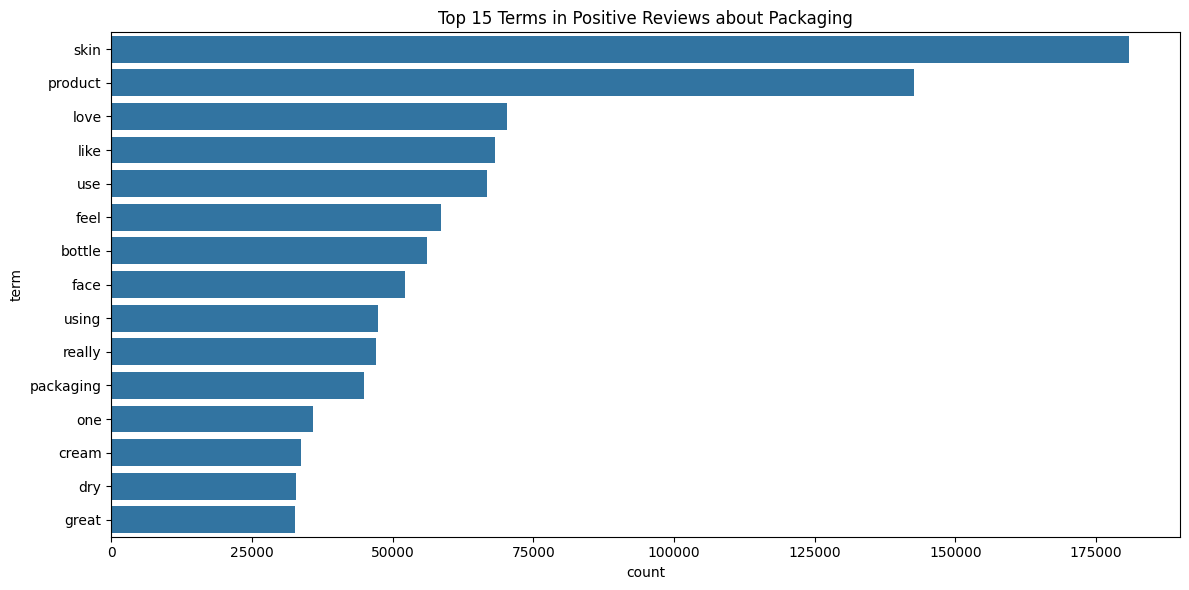

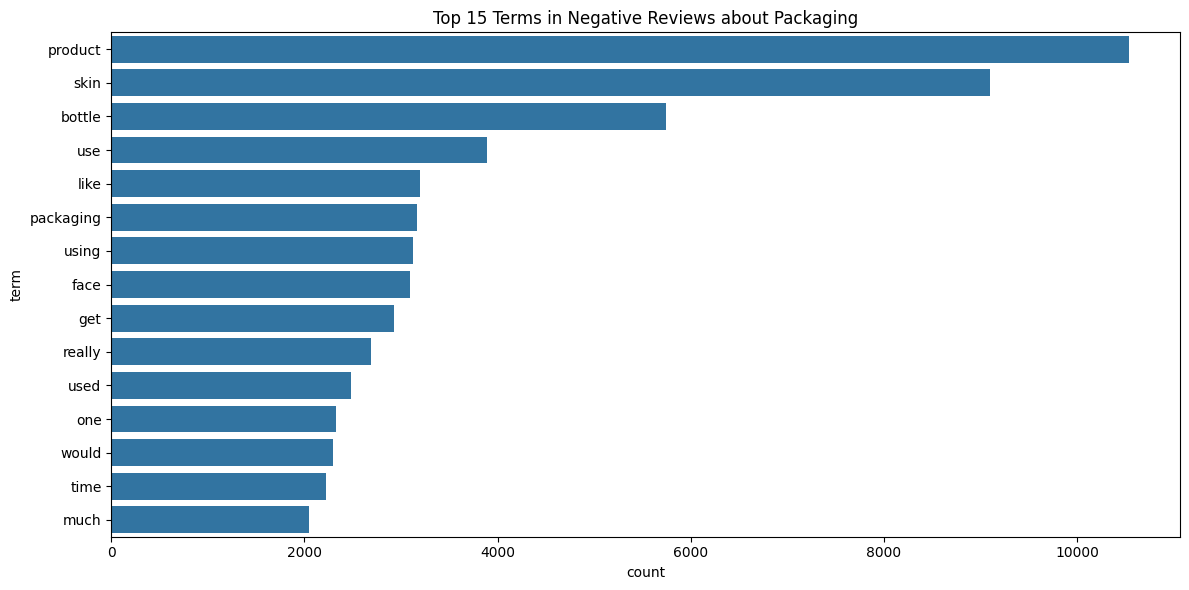


Analyzing texture...


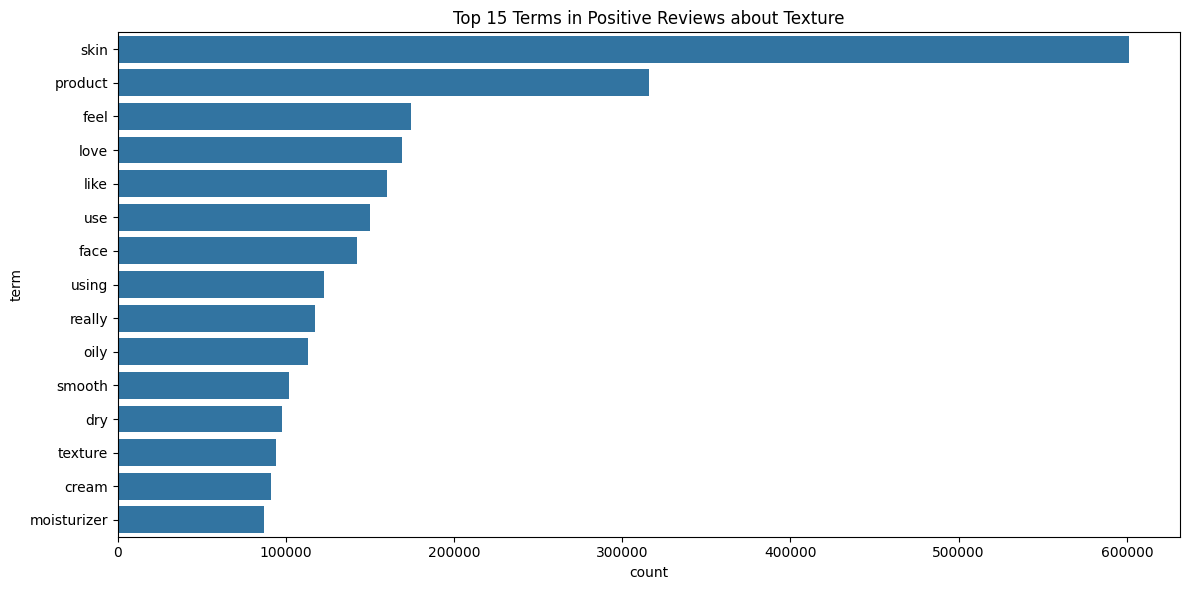

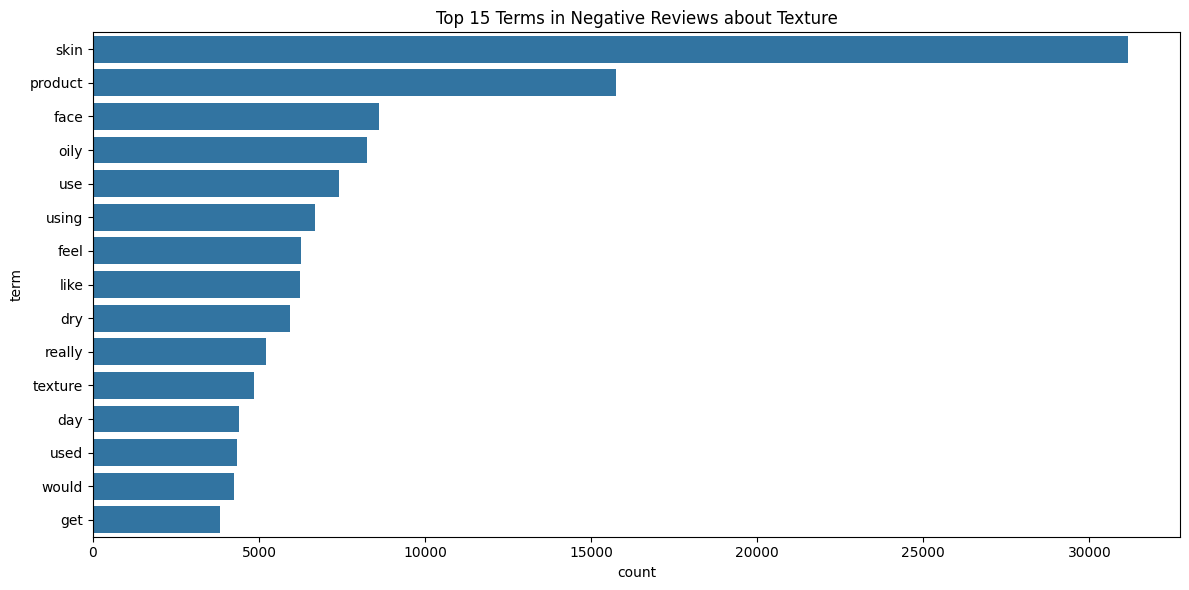


Analyzing scent...


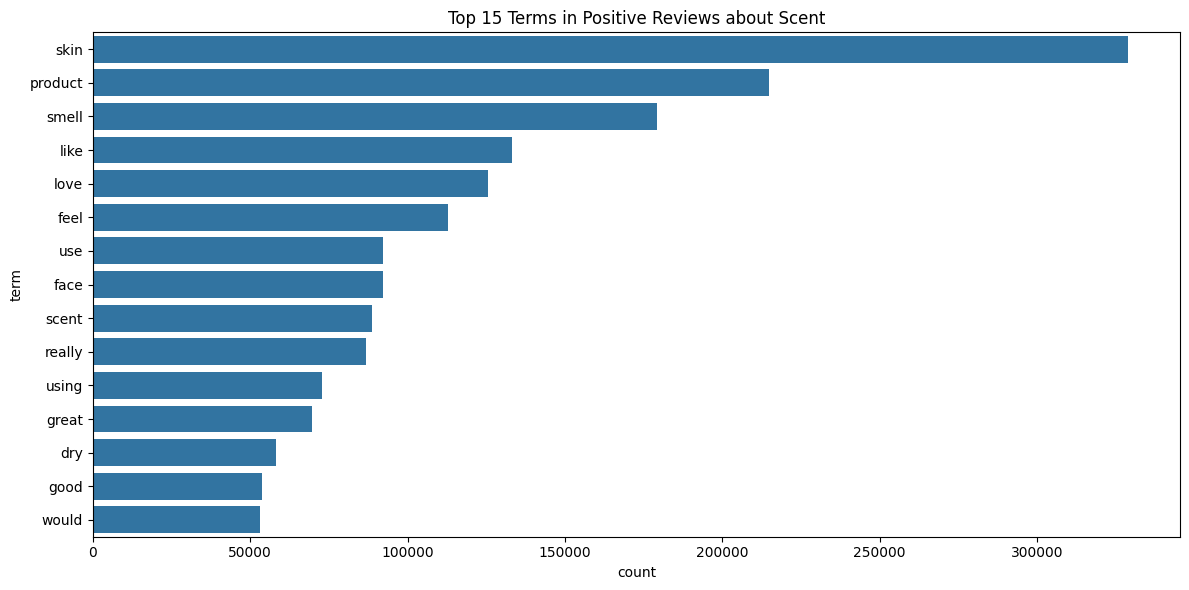

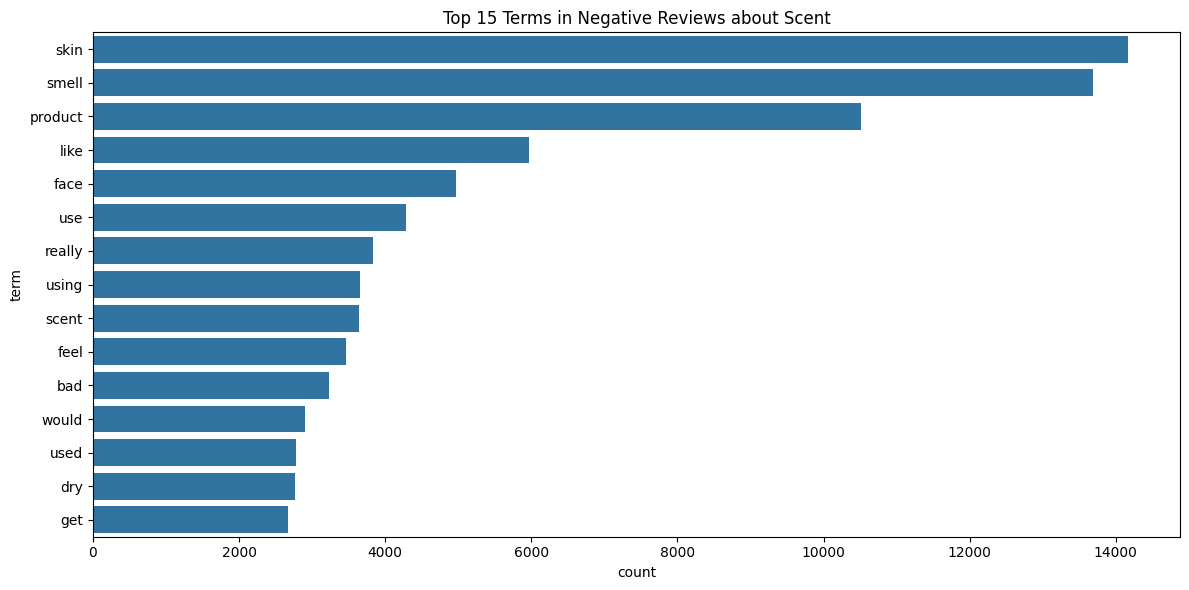


Analyzing efficacy...


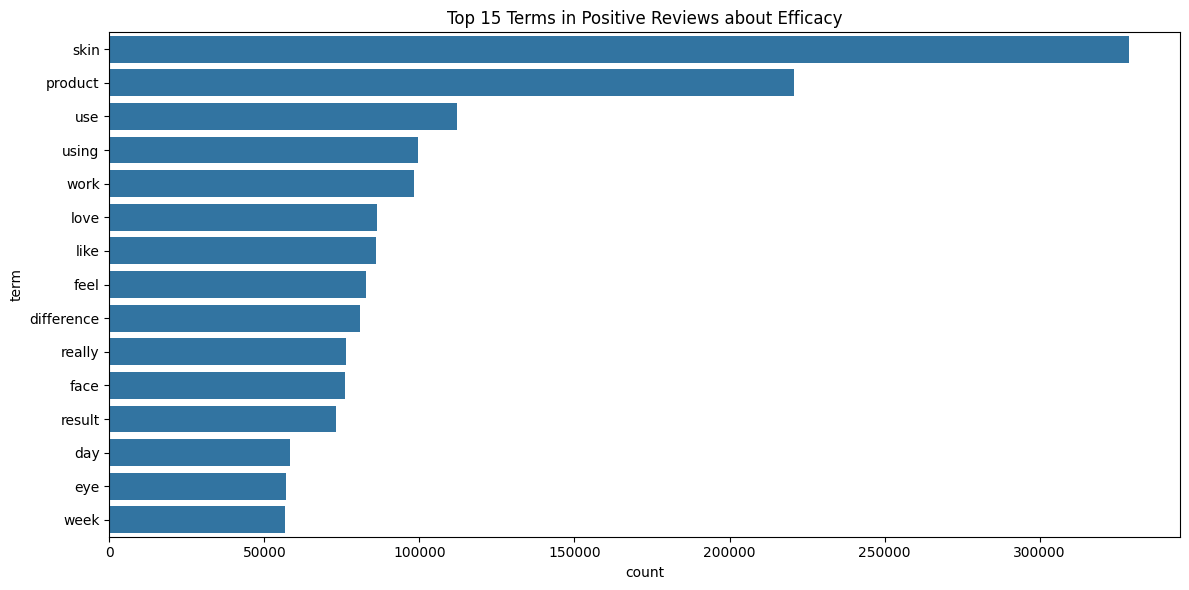

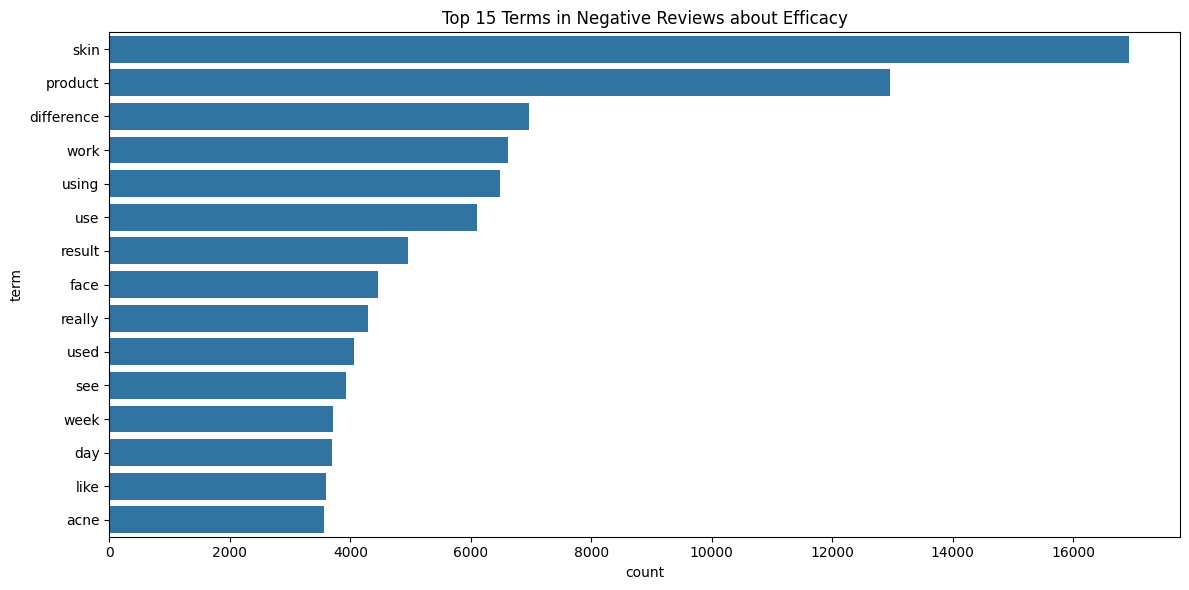


Analyzing ingredients...


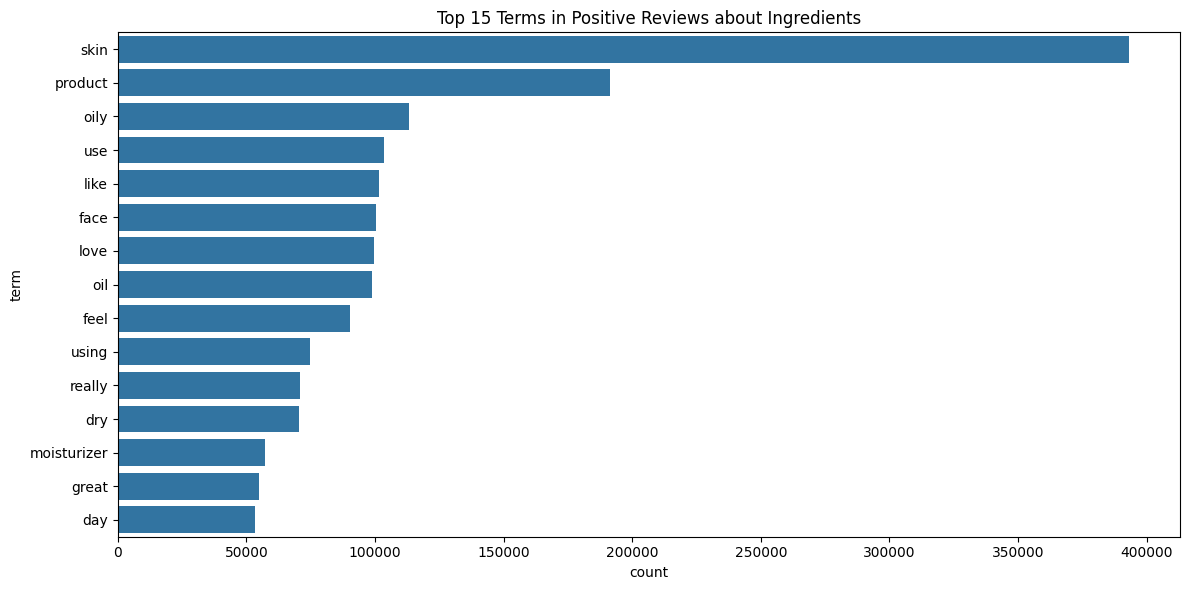

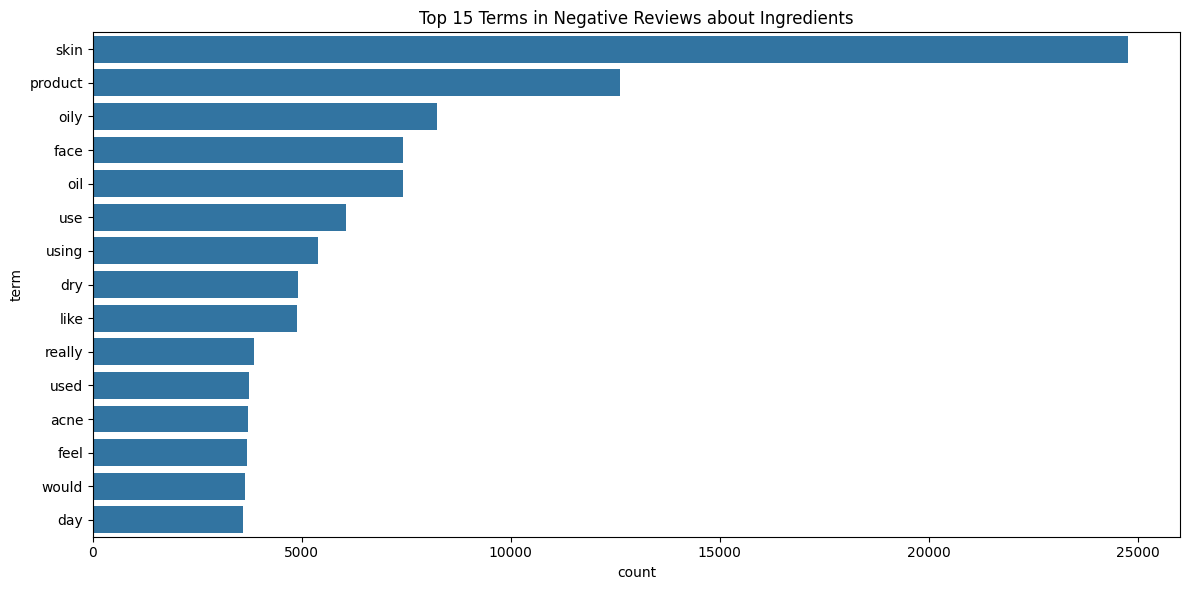


Analyzing longevity...


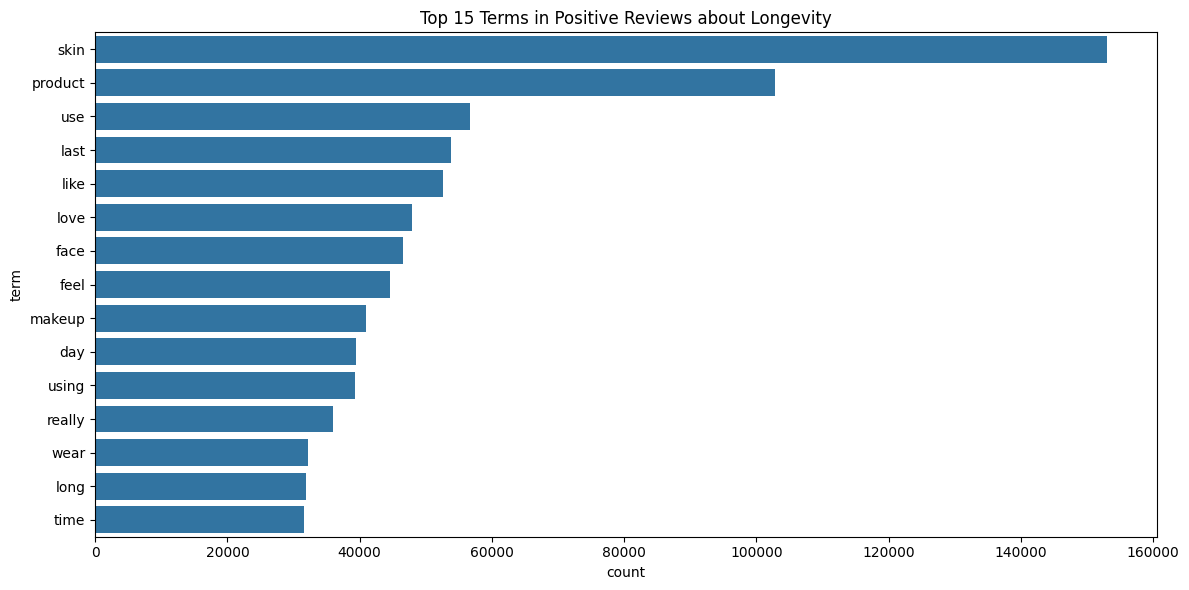

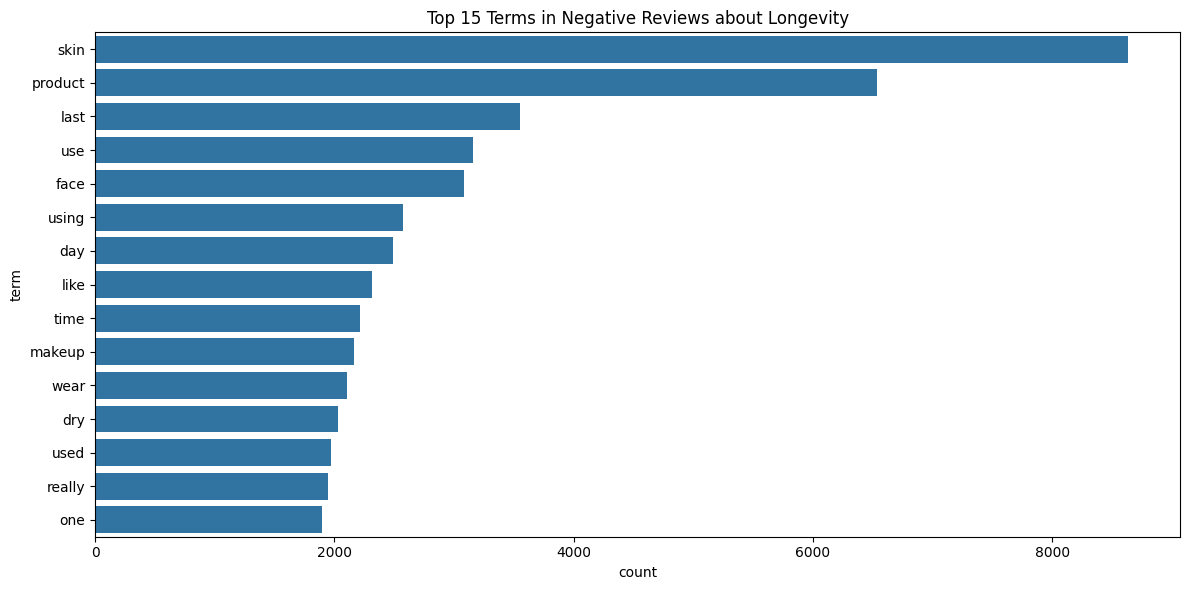


Analyzing value...


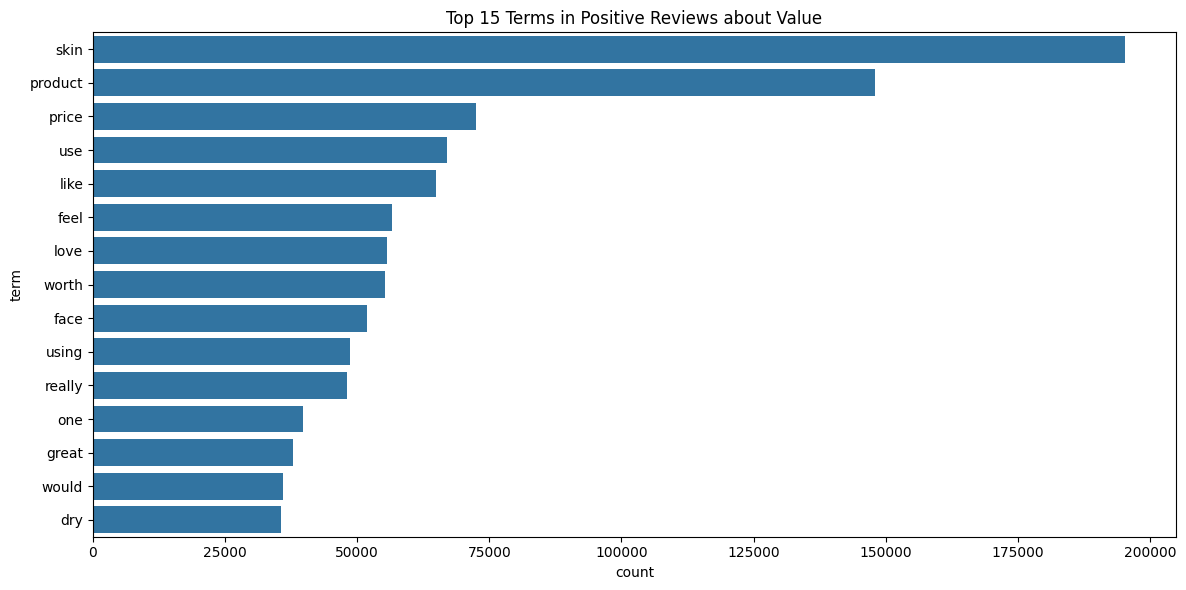

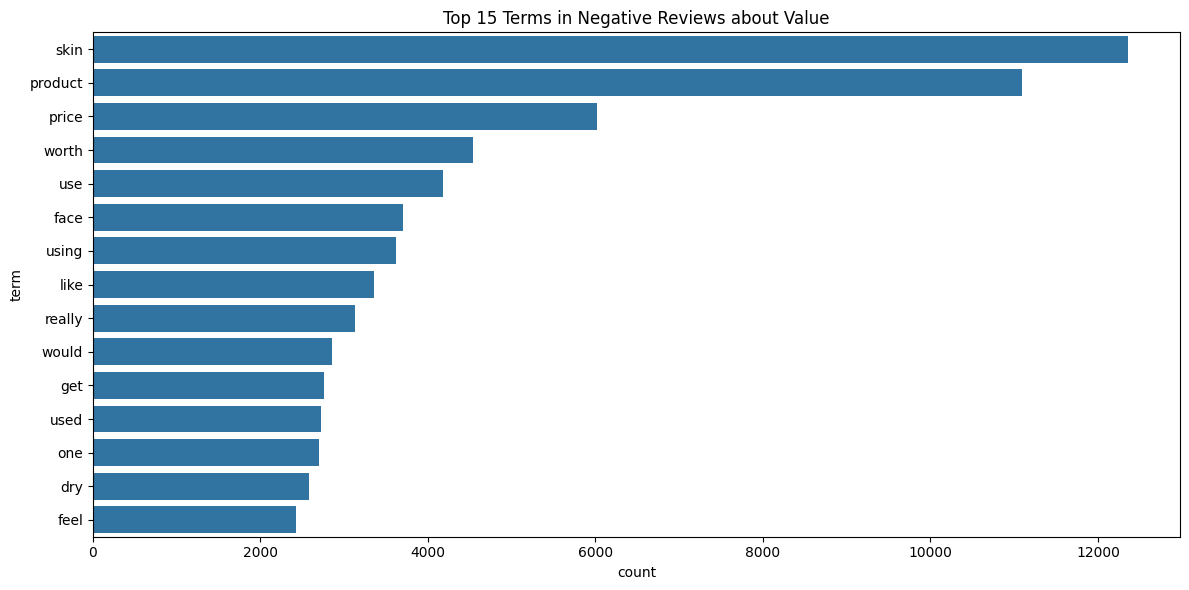


Analyzing application...


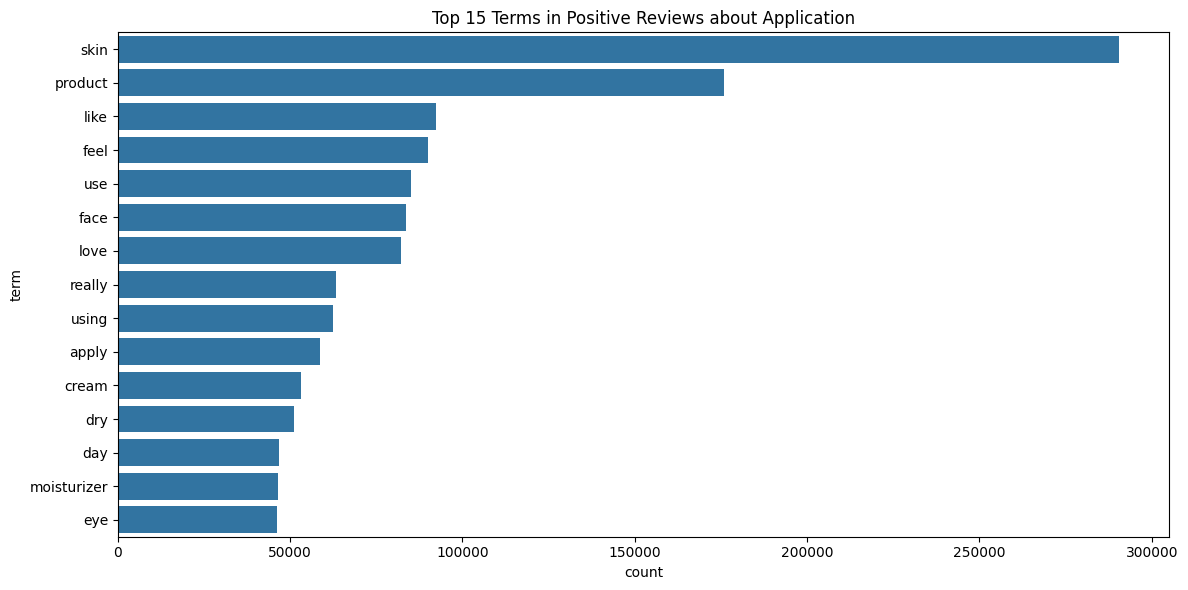

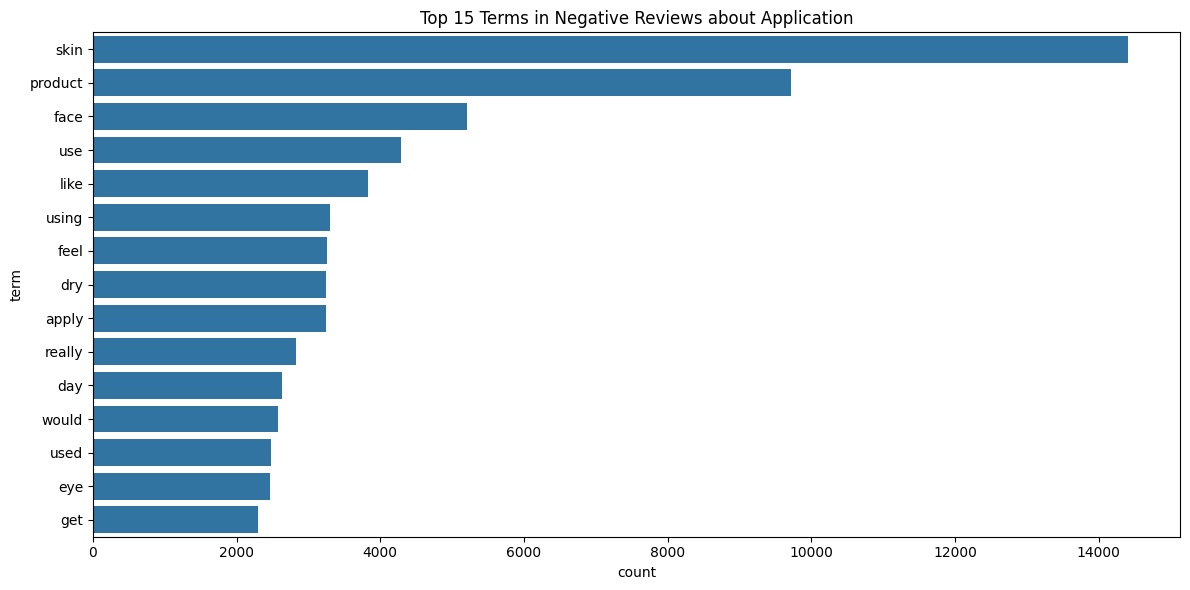


Analyzing color...


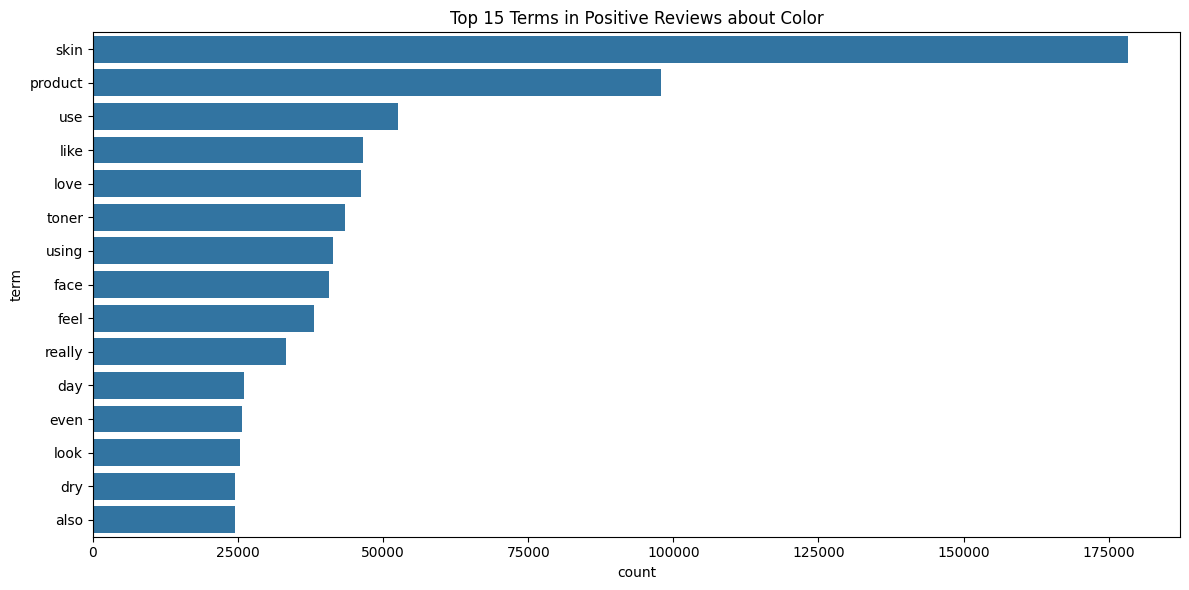

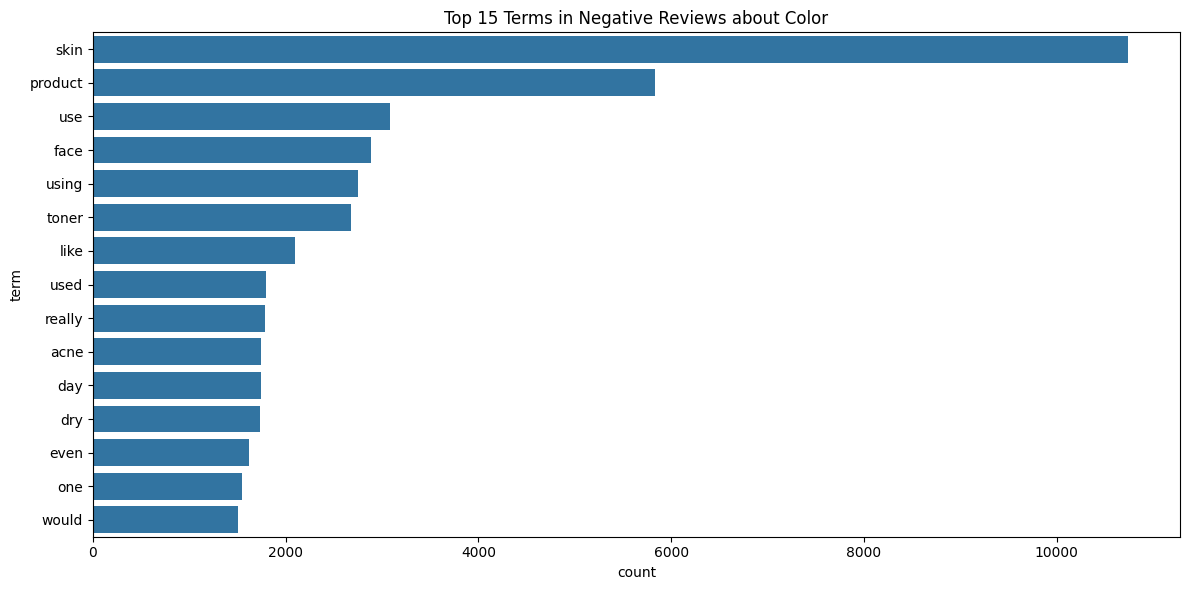

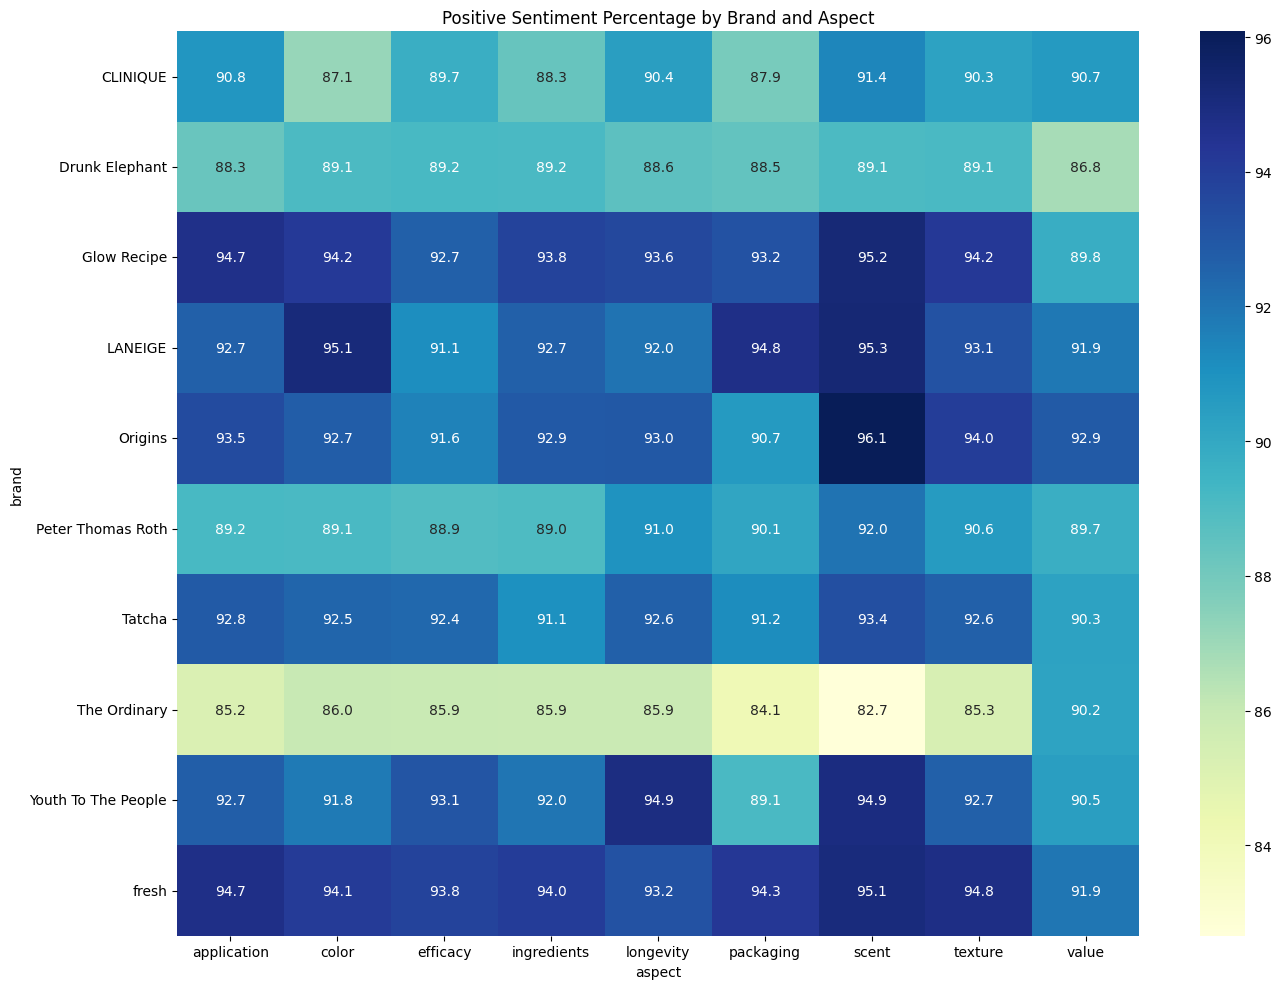

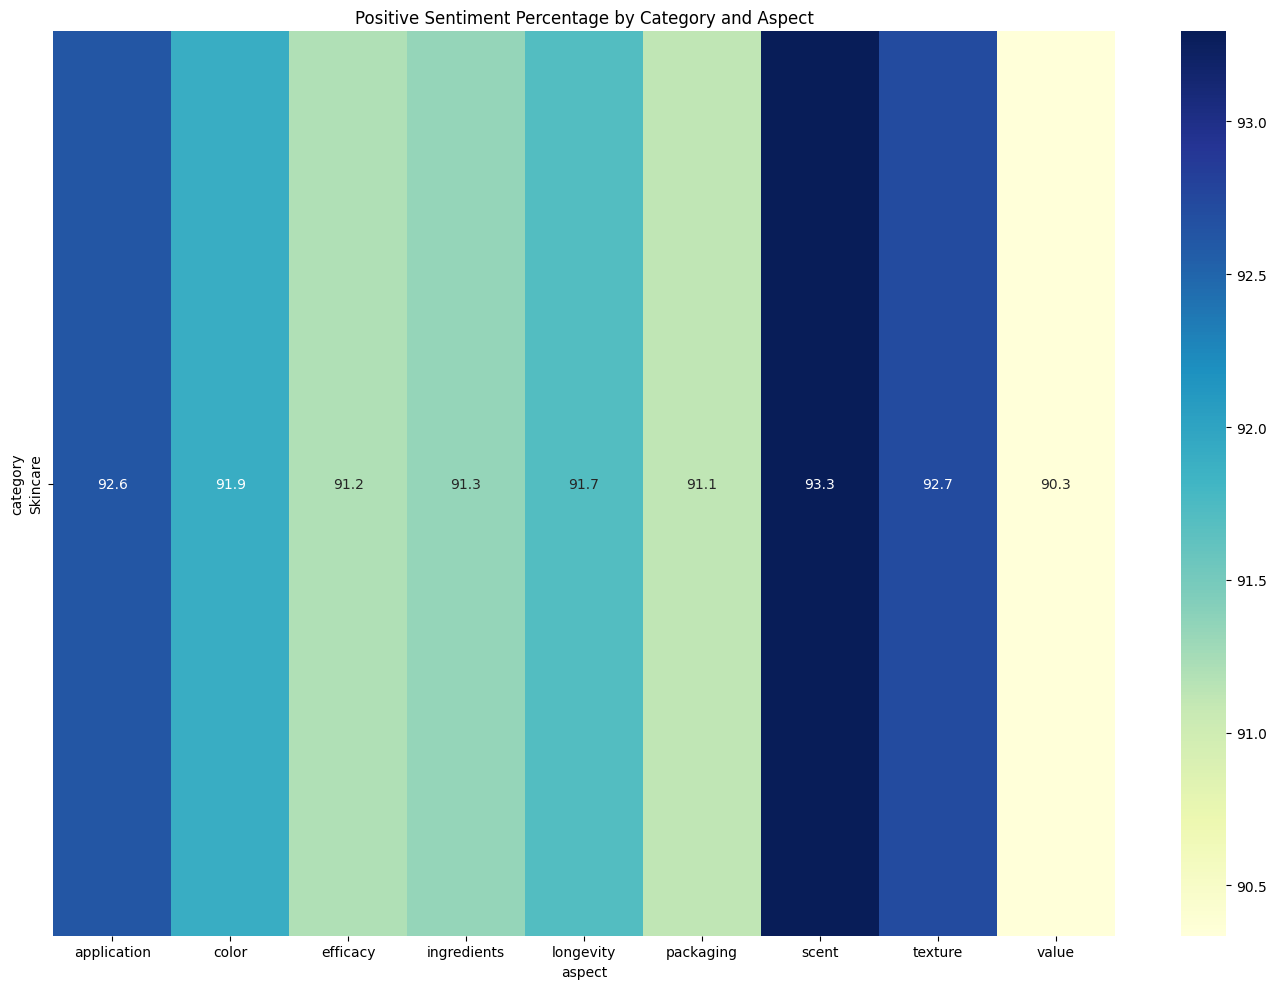

In [84]:
import json

# Create a function to visualize the most common terms for each aspect with sentiment
def visualize_aspect_terms(data, aspect, sentiment='positive', top_n=15):
    # Filter reviews that mention this aspect and have the specified sentiment
    if sentiment == 'positive':
        filtered_data = data[(data[f'has_{aspect}'] == 1) & (data['compound_score'] > 0.05)]
    elif sentiment == 'negative':
        filtered_data = data[(data[f'has_{aspect}'] == 1) & (data['compound_score'] < -0.05)]
    else:
        filtered_data = data[(data[f'has_{aspect}'] == 1) & 
                             (data['compound_score'] >= -0.05) & 
                             (data['compound_score'] <= 0.05)]
    
    # Combine all processed text
    all_text = ' '.join(filtered_data['processed_text'].fillna(''))
    
    # Count term frequencies
    vectorizer = CountVectorizer(max_features=top_n)
    term_counts = vectorizer.fit_transform([all_text])
    
    # Get the terms and their counts
    terms = vectorizer.get_feature_names_out()
    counts = term_counts.toarray()[0]
    
    # Create a dataframe for visualization
    term_df = pd.DataFrame({'term': terms, 'count': counts})
    term_df = term_df.sort_values('count', ascending=False)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='term', data=term_df)
    plt.title(f'Top {top_n} Terms in {sentiment.capitalize()} Reviews about {aspect.capitalize()}')
    plt.tight_layout()
    plt.show()

# Visualize top terms for each aspect with positive and negative sentiment
for aspect in beauty_aspects.keys():
    print(f"\nAnalyzing {aspect}...")
    visualize_aspect_terms(merged_data, aspect, 'positive')
    visualize_aspect_terms(merged_data, aspect, 'negative')

# Create a brand-aspect sentiment matrix
def create_brand_aspect_sentiment(data, brands, aspects):
    brand_aspect_sentiment = []
    
    for brand in brands:
        brand_data = data[data['brand_name'] == brand]
        
        for aspect in aspects:
            # Filter reviews that mention this aspect for this brand
            aspect_reviews = brand_data[brand_data[f'has_{aspect}'] == 1]
            
            if aspect_reviews.shape[0] < 5:  # Skip if too few reviews
                continue
            
            # Calculate sentiment metrics
            avg_rating = aspect_reviews['rating_x'].mean()
            avg_compound = aspect_reviews['compound_score'].mean()
            
            pos_count = sum((aspect_reviews['compound_score'] > 0.05))
            neu_count = sum((aspect_reviews['compound_score'] >= -0.05) & (aspect_reviews['compound_score'] <= 0.05))
            neg_count = sum((aspect_reviews['compound_score'] < -0.05))
            
            total_count = pos_count + neu_count + neg_count
            
            if total_count > 0:
                brand_aspect_sentiment.append({
                    'brand': brand,
                    'aspect': aspect,
                    'avg_rating': avg_rating,
                    'avg_compound': avg_compound,
                    'positive_pct': pos_count / total_count * 100,
                    'neutral_pct': neu_count / total_count * 100,
                    'negative_pct': neg_count / total_count * 100,
                    'total_reviews': total_count
                })
    
    return pd.DataFrame(brand_aspect_sentiment)

# Get top brands by review count
top_brands = merged_data['brand_name'].value_counts().head(10).index.tolist()

# Create the brand-aspect sentiment matrix
brand_aspect_df = create_brand_aspect_sentiment(merged_data, top_brands, beauty_aspects.keys())

# Create a heatmap of positive sentiment percentage by brand and aspect
brand_aspect_pivot = brand_aspect_df.pivot_table(
    index='brand', 
    columns='aspect', 
    values='positive_pct',
    aggfunc='mean'
)

plt.figure(figsize=(14, 10))
sns.heatmap(brand_aspect_pivot, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Positive Sentiment Percentage by Brand and Aspect')
plt.tight_layout()
plt.show()

# Create a function for category-based ABSA
def analyze_category_aspects(data, category_col, aspects):
    category_aspect_sentiment = []
    
    for category in data[category_col].unique():
        if pd.isna(category):
            continue
            
        category_data = data[data[category_col] == category]
        
        for aspect in aspects:
            # Filter reviews that mention this aspect for this category
            aspect_reviews = category_data[category_data[f'has_{aspect}'] == 1]
            
            if aspect_reviews.shape[0] < 5:  # Skip if too few reviews
                continue
            
            # Calculate sentiment metrics
            avg_rating = aspect_reviews['rating_x'].mean()
            avg_compound = aspect_reviews['compound_score'].mean()
            
            pos_count = sum((aspect_reviews['compound_score'] > 0.05))
            neu_count = sum((aspect_reviews['compound_score'] >= -0.05) & (aspect_reviews['compound_score'] <= 0.05))
            neg_count = sum((aspect_reviews['compound_score'] < -0.05))
            
            total_count = pos_count + neu_count + neg_count
            
            if total_count > 0:
                category_aspect_sentiment.append({
                    'category': category,
                    'aspect': aspect,
                    'avg_rating': avg_rating,
                    'avg_compound': avg_compound,
                    'positive_pct': pos_count / total_count * 100,
                    'neutral_pct': neu_count / total_count * 100,
                    'negative_pct': neg_count / total_count * 100,
                    'total_reviews': total_count
                })
    
    return pd.DataFrame(category_aspect_sentiment)

# Analyze primary category aspects
category_aspect_df = analyze_category_aspects(merged_data, 'primary_category', beauty_aspects.keys())

# Create a heatmap of positive sentiment percentage by category and aspect
category_aspect_pivot = category_aspect_df.pivot_table(
    index='category', 
    columns='aspect', 
    values='positive_pct',
    aggfunc='mean'
)

plt.figure(figsize=(14, 10))
sns.heatmap(category_aspect_pivot, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Positive Sentiment Percentage by Category and Aspect')
plt.tight_layout()
plt.show()

## Real-World Applications and Dashboard Creation

In [98]:
# Create a function to find similar products based on aspect sentiments
def find_similar_products(data, product_id, top_n=5):
    """Find products with similar aspect sentiment profiles"""
    
    # Get the aspect sentiment profile for the target product
    target_product = data[data['product_id'] == product_id]
    
    if target_product.shape[0] == 0:
        return "Product not found"
    
    target_name = target_product['product_name'].iloc[0]
    target_brand = target_product['brand_name'].iloc[0]
    
    # Calculate product-aspect sentiment profiles for all products
    products = []
    
    for pid in data['product_id'].unique():
        product_data = data[data['product_id'] == pid]
        
        if product_data.shape[0] < 3:  # Skip products with few reviews
            continue
            
        product_info = {
            'product_id': pid,
            'product_name': product_data['product_name'].iloc[0],
            'brand_name': product_data['brand_name'].iloc[0],
            'avg_rating': product_data['rating_x'].mean(),
            'review_count': product_data.shape[0]
        }
        
        # Add aspect sentiment scores
        for aspect in beauty_aspects.keys():
            aspect_reviews = product_data[product_data[f'has_{aspect}'] == 1]
            
            if aspect_reviews.shape[0] > 0:
                product_info[f'{aspect}_sentiment'] = aspect_reviews['compound_score'].mean()
            else:
                product_info[f'{aspect}_sentiment'] = 0
                
        products.append(product_info)
    
    products_df = pd.DataFrame(products)
    
    # Get the target product data
    target_profile = products_df[products_df['product_id'] == product_id]
    
    if target_profile.shape[0] == 0:
        return "Not enough reviews for similarity calculation"
    
    # Remove the target product
    products_df = products_df[products_df['product_id'] != product_id]
    
    # Calculate similarity based on aspect sentiment scores
    aspect_cols = [f'{aspect}_sentiment' for aspect in beauty_aspects.keys()]
    
    from sklearn.metrics.pairwise import cosine_similarity
    
    target_features = target_profile[aspect_cols].values
    other_features = products_df[aspect_cols].values
    
    similarities = cosine_similarity(target_features, other_features)[0]
    
    # Add similarity to the dataframe
    products_df['similarity'] = similarities
    
    # Return top N similar products
    similar_products = products_df.sort_values('similarity', ascending=False).head(top_n)
    
    return {
        'target_product': {
            'product_id': product_id,
            'product_name': target_name,
            'brand_name': target_brand
        },
        'similar_products': similar_products[['product_id', 'product_name', 'brand_name', 'avg_rating', 'similarity']].to_dict('records')
    }

# Test the similar products function with a sample product
sample_product_id = merged_data['product_id'].iloc[1]
similar_products = find_similar_products(merged_data, sample_product_id)
print("\nSimilar Products:")
print(json.dumps(similar_products, indent=4))

# Create a function for product recommendation based on aspect preferences
def recommend_products(data, aspect_preferences, top_n=5):
    """
    Recommend products based on aspect preferences
    
    aspect_preferences: dict with aspect names as keys and importance scores (0-10) as values
    """
    
    # Normalize aspect preferences
    total_importance = sum(aspect_preferences.values())
    normalized_preferences = {k: v/total_importance for k, v in aspect_preferences.items() if v > 0}
    
    # Calculate product-aspect sentiment profiles for all products
    products = []
    
    for pid in data['product_id'].unique():
        product_data = data[data['product_id'] == pid]
        
        if product_data.shape[0] < 5:  # Skip products with few reviews
            continue
            
        product_info = {
            'product_id': pid,
            'product_name': product_data['product_name'].iloc[0],
            'brand_name': product_data['brand_name'].iloc[0],
            'primary_category': product_data['primary_category'].iloc[0] if 'primary_category' in product_data.columns else 'Unknown',
            'avg_rating': product_data['rating_x'].mean(),
            'review_count': product_data.shape[0]
        }
        
        # Add aspect sentiment scores
        aspect_score = 0
        
        for aspect, importance in normalized_preferences.items():
            aspect_reviews = product_data[product_data[f'has_{aspect}'] == 1]
            
            if aspect_reviews.shape[0] > 0:
                sentiment = aspect_reviews['compound_score'].mean()
                # Convert to a 0-1 scale (from -1 to 1)
                normalized_sentiment = (sentiment + 1) / 2
                aspect_score += normalized_sentiment * importance
                product_info[f'{aspect}_sentiment'] = sentiment
            else:
                product_info[f'{aspect}_sentiment'] = 0
        
        product_info['aspect_score'] = aspect_score
        products.append(product_info)
    
    products_df = pd.DataFrame(products)
    
    # Return top N products by aspect score
    recommended_products = products_df.sort_values('aspect_score', ascending=False).head(top_n)
    
    return recommended_products[['product_id', 'product_name', 'brand_name', 'primary_category', 'avg_rating', 'review_count', 'aspect_score'] + 
                               [f'{aspect}_sentiment' for aspect in normalized_preferences.keys()]]



Similar Products:
{
    "target_product": {
        "product_id": "P420652",
        "product_name": "Lip Sleeping Mask Intense Hydration with Vitamin C",
        "brand_name": "LANEIGE"
    },
    "similar_products": [
        {
            "product_id": "P454313",
            "product_name": "Cica Sleeping Mask",
            "brand_name": "LANEIGE",
            "avg_rating": 4.6366427840327535,
            "similarity": 0.9998449207564253
        },
        {
            "product_id": "P266126",
            "product_name": "Rosebud Salve in a Tube",
            "brand_name": "Rosebud Perfume Co.",
            "avg_rating": 4.37974155898291,
            "similarity": 0.9996029817358307
        },
        {
            "product_id": "P446930",
            "product_name": "Cream Skin Toner & Moisturizer",
            "brand_name": "LANEIGE",
            "avg_rating": 4.448793565683646,
            "similarity": 0.9995776041659655
        },
        {
            "product_id": "P460516"


Recommended Products Based on Aspect Preferences:
     product_id                                       product_name   brand_name primary_category  avg_rating  review_count  aspect_score  efficacy_sentiment  texture_sentiment  value_sentiment  packaging_sentiment  scent_sentiment
1887    P429508                      Sunless Tan Dry Body Oil Mist        COOLA         Skincare    4.347826            23      0.973850            0.995100           0.930200         0.927400             0.922650         0.906827
2091    P503123                             Smooth Like Butter Kit  Josie Maran         Skincare    4.500000            10      0.971736            0.993700           0.961300         0.868850             0.993700         0.864760
1590    P375854                             Ultimate Revival Cream        SK-II         Skincare    4.466667            60      0.970190            0.949936           0.932951         0.925464             0.958282         0.942679
1127    P469444          

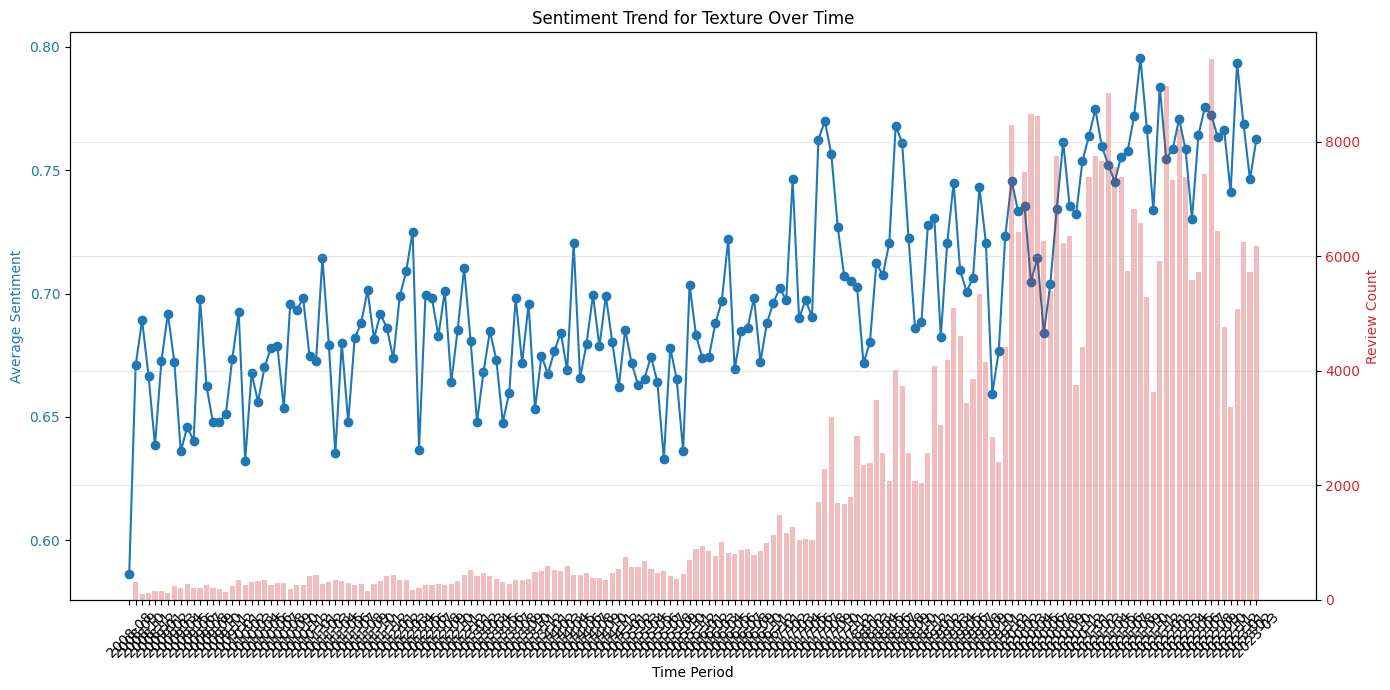

In [86]:
# Test the recommendation function with sample preferences
sample_preferences = {
    'efficacy': 8,
    'texture': 6,
    'value': 5,
    'packaging': 2,
    'scent': 3
}

recommendations = recommend_products(merged_data, sample_preferences)
print("\nRecommended Products Based on Aspect Preferences:")
print(recommendations)

# Create a function to analyze aspect sentiment trends over time
def analyze_aspect_trends(data, aspect, time_unit='month'):
    """Analyze how sentiment for a specific aspect changes over time"""
    
    # Ensure we have datetime
    data['submission_time'] = pd.to_datetime(data['submission_time'])
    
    # Filter reviews that mention this aspect
    aspect_data = data[data[f'has_{aspect}'] == 1].copy()
    
    if aspect_data.shape[0] < 10:
        return f"Not enough data for aspect: {aspect}"
    
    # Group by time unit
    if time_unit == 'month':
        aspect_data['time_period'] = aspect_data['submission_time'].dt.to_period('M')
    elif time_unit == 'quarter':
        aspect_data['time_period'] = aspect_data['submission_time'].dt.to_period('Q')
    elif time_unit == 'year':
        aspect_data['time_period'] = aspect_data['submission_time'].dt.to_period('Y')
    else:
        return "Invalid time unit. Use 'month', 'quarter', or 'year'."
    
    # Calculate average sentiment by time period
    sentiment_trends = aspect_data.groupby('time_period').agg({
        'compound_score': 'mean',
        'rating_x': 'mean',
        'product_id': 'count'
    }).reset_index()
    
    sentiment_trends.columns = ['time_period', 'avg_sentiment', 'avg_rating', 'review_count']
    sentiment_trends['time_period'] = sentiment_trends['time_period'].astype(str)
    
    # Plot the trends
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    color = 'tab:blue'
    ax1.set_xlabel('Time Period')
    ax1.set_ylabel('Average Sentiment', color=color)
    ax1.plot(sentiment_trends['time_period'], sentiment_trends['avg_sentiment'], color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticklabels(sentiment_trends['time_period'], rotation=45)
    
    # Create a second y-axis for review count
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Review Count', color=color)
    ax2.bar(sentiment_trends['time_period'], sentiment_trends['review_count'], color=color, alpha=0.3)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title(f'Sentiment Trend for {aspect.capitalize()} Over Time')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return sentiment_trends

# Test the trend analysis function for a sample aspect
sample_trend = analyze_aspect_trends(merged_data, 'texture', 'month')

## Creating a Topic Model for Deeper Aspect Analysis

Topic 1: makeup sunscreen skin love product like look foundation day moisturizer
Topic 2: product skin acne using day used use work got week
Topic 3: skin product feel love received scent light like moisturizer smell
Topic 4: eye cream line fine use product using night area dark
Topic 5: little long product way price skin bit worth like good
Topic 6: skin dry sensitive use oily moisturizer love product feel oil
Topic 7: face cleanser skin clean love feeling feel product really wash
Topic 8: skin product using serum week use difference result love routine
Topic 9: lip makeup balm love use remove product cleansing great dry
Topic 10: like face product smell mask feel really use skin good


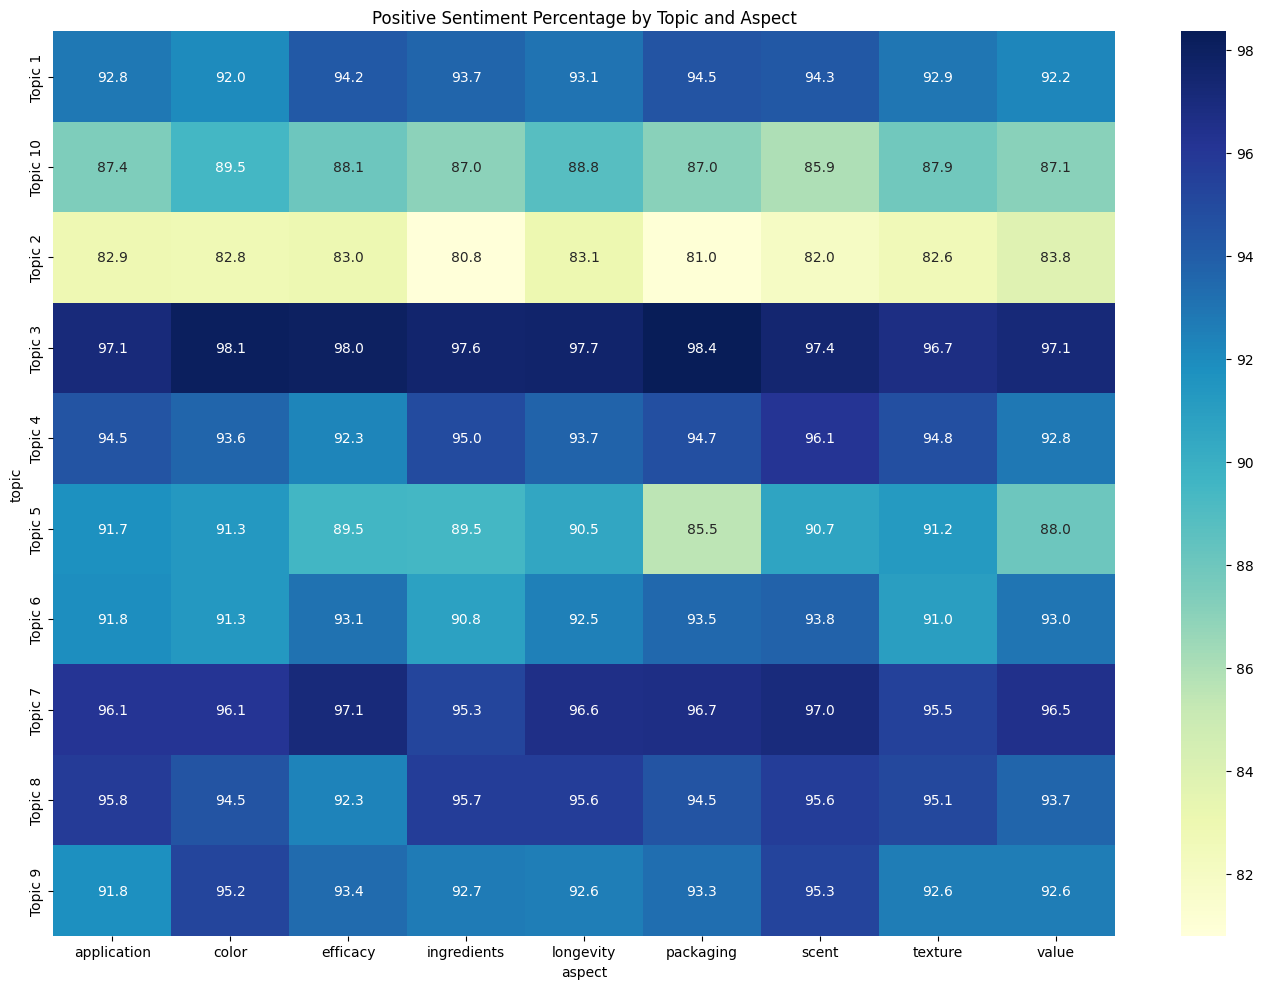

In [87]:
# We'll use Latent Dirichlet Allocation (LDA) to find topics in reviews
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Create document-term matrix
count_vect = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features=1000)
doc_term_matrix = count_vect.fit_transform(merged_data['processed_text'].fillna(''))

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(doc_term_matrix)

# Function to display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics[f"Topic {topic_idx+1}"] = topic_words
        print(f"Topic {topic_idx+1}: {' '.join(topic_words)}")
    return topics

# Display the top 10 words for each topic
feature_names = count_vect.get_feature_names_out()
topics = display_topics(lda, feature_names, 10)

# Transform the document-term matrix to get topic distributions for each review
topic_distributions = lda.transform(doc_term_matrix)

# Add the dominant topic to each review
merged_data['dominant_topic'] = topic_distributions.argmax(axis=1) + 1

# Calculate aspect sentiment by topic
topic_aspect_sentiment = []

for topic_num in range(1, lda.n_components + 1):
    topic_reviews = merged_data[merged_data['dominant_topic'] == topic_num]
    
    for aspect in beauty_aspects.keys():
        # Filter reviews that mention this aspect for this topic
        aspect_reviews = topic_reviews[topic_reviews[f'has_{aspect}'] == 1]
        
        if aspect_reviews.shape[0] < 5:  # Skip if too few reviews
            continue
        
        # Calculate sentiment metrics
        avg_rating = aspect_reviews['rating_x'].mean()
        avg_compound = aspect_reviews['compound_score'].mean()
        
        pos_count = sum((aspect_reviews['compound_score'] > 0.05))
        neu_count = sum((aspect_reviews['compound_score'] >= -0.05) & (aspect_reviews['compound_score'] <= 0.05))
        neg_count = sum((aspect_reviews['compound_score'] < -0.05))
        
        total_count = pos_count + neu_count + neg_count
        
        if total_count > 0:
            topic_aspect_sentiment.append({
                'topic': f"Topic {topic_num}",
                'topic_words': ' '.join(topics[f"Topic {topic_num}"]),
                'aspect': aspect,
                'avg_rating': avg_rating,
                'avg_compound': avg_compound,
                'positive_pct': pos_count / total_count * 100,
                'neutral_pct': neu_count / total_count * 100,
                'negative_pct': neg_count / total_count * 100,
                'total_reviews': total_count
            })

topic_aspect_df = pd.DataFrame(topic_aspect_sentiment)

# Create a heatmap of positive sentiment percentage by topic and aspect
topic_aspect_pivot = topic_aspect_df.pivot_table(
    index='topic', 
    columns='aspect', 
    values='positive_pct',
    aggfunc='mean'
)

plt.figure(figsize=(14, 10))
sns.heatmap(topic_aspect_pivot, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Positive Sentiment Percentage by Topic and Aspect')
plt.tight_layout()
plt.show()

## Building a Product Review Analyzer Tool

In [88]:
# Create a function to analyze a single product in depth
def analyze_product(data, product_id):
    """Comprehensive analysis of a single product"""
    
    # Filter data for this product
    product_data = data[data['product_id'] == product_id].copy()
    
    if product_data.shape[0] == 0:
        return "Product not found"
    
    # Basic product information
    product_info = {
        'product_id': product_id,
        'product_name': product_data['product_name'].iloc[0],
        'brand_name': product_data['brand_name'].iloc[0],
        'primary_category': product_data['primary_category'].iloc[0] if 'primary_category' in product_data.columns else 'Unknown',
        'price_usd': product_data['price_usd'].iloc[0],
        'review_count': product_data.shape[0],
        'avg_rating': product_data['rating_x'].mean(),
        'avg_sentiment': product_data['compound_score'].mean()
    }
    
    # Aspect analysis
    aspect_analysis = []
    
    for aspect in beauty_aspects.keys():
        # Filter reviews that mention this aspect
        aspect_reviews = product_data[product_data[f'has_{aspect}'] == 1]
        
        if aspect_reviews.shape[0] == 0:
            continue
        
        # Calculate sentiment metrics
        avg_rating = aspect_reviews['rating_x'].mean()
        avg_compound = aspect_reviews['compound_score'].mean()
        
        pos_count = sum((aspect_reviews['compound_score'] > 0.05))
        neu_count = sum((aspect_reviews['compound_score'] >= -0.05) & (aspect_reviews['compound_score'] <= 0.05))
        neg_count = sum((aspect_reviews['compound_score'] < -0.05))
        
        total_count = pos_count + neu_count + neg_count
        
        # Find most positive and negative reviews for this aspect
        if pos_count > 0:
            most_positive = aspect_reviews.loc[aspect_reviews['compound_score'].idxmax()]
            pos_review = {
                'text': most_positive['review_text'],
                'rating': most_positive['rating_x'],
                'sentiment': most_positive['compound_score']
            }
        else:
            pos_review = None
            
        if neg_count > 0:
            most_negative = aspect_reviews.loc[aspect_reviews['compound_score'].idxmin()]
            neg_review = {
                'text': most_negative['review_text'],
                'rating': most_negative['rating_x'],
                'sentiment': most_negative['compound_score']
            }
        else:
            neg_review = None
        
        aspect_analysis.append({
            'aspect': aspect,
            'mention_count': aspect_reviews.shape[0],
            'mention_percentage': aspect_reviews.shape[0] / product_data.shape[0] * 100,
            'avg_rating': avg_rating,
            'avg_sentiment': avg_compound,
            'positive_pct': pos_count / total_count * 100 if total_count > 0 else 0,
            'neutral_pct': neu_count / total_count * 100 if total_count > 0 else 0,
            'negative_pct': neg_count / total_count * 100 if total_count > 0 else 0,
            'most_positive_review': pos_review,
            'most_negative_review': neg_review
        })
    
    # Sort aspects by mention count
    aspect_analysis = sorted(aspect_analysis, key=lambda x: x['mention_count'], reverse=True)
    
    # Find key strengths and weaknesses
    strengths = [a for a in aspect_analysis if a['avg_sentiment'] > 0.1][:3]
    weaknesses = [a for a in aspect_analysis if a['avg_sentiment'] < -0.1][:3]
    
    # Create visualizations
    visualizations = {}
    
    # 1. Aspect sentiment distribution
    aspect_df = pd.DataFrame(aspect_analysis)
    if not aspect_df.empty:
        plt.figure(figsize=(12, 8))
        
        aspect_df = aspect_df.sort_values('avg_sentiment', ascending=False)
        sns.barplot(x='avg_sentiment', y='aspect', data=aspect_df, palette='RdYlGn')
        
        plt.axvline(x=0, color='gray', linestyle='--')
        plt.title(f'Aspect Sentiment Analysis for {product_info["product_name"]}')
        plt.xlabel('Average Sentiment Score')
        plt.tight_layout()
        
        # Save figure to buffer
        from io import BytesIO
        import base64
        
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        visualizations['aspect_sentiment'] = base64.b64encode(buf.read()).decode('utf-8')
        plt.close()
    
    # Return complete analysis
    return {
        'product_info': product_info,
        'aspect_analysis': aspect_analysis,
        'strengths': strengths,
        'weaknesses': weaknesses,
        'visualizations': visualizations
    }

# Test the product analyzer with a sample product
sample_product_id = merged_data['product_id'].iloc[0]
product_analysis = analyze_product(merged_data, sample_product_id)

# Print summary of the analysis
print("\nProduct Analysis Summary:")
print(f"Product: {product_analysis['product_info']['product_name']} by {product_analysis['product_info']['brand_name']}")
print(f"Average Rating: {product_analysis['product_info']['avg_rating']:.2f}")
print(f"Review Count: {product_analysis['product_info']['review_count']}")
print("\nAspects Mentioned (Top 3):")

for aspect in product_analysis['aspect_analysis'][:3]:
    print(f"- {aspect['aspect'].capitalize()}: {aspect['mention_count']} mentions, {aspect['avg_sentiment']:.2f} sentiment")

print("\nStrengths:")
for strength in product_analysis['strengths']:
    print(f"- {strength['aspect'].capitalize()}: {strength['avg_sentiment']:.2f} sentiment")

print("\nWeaknesses:")
for weakness in product_analysis['weaknesses']:
    print(f"- {weakness['aspect'].capitalize()}: {weakness['avg_sentiment']:.2f} sentiment")


Product Analysis Summary:
Product: Gentle Hydra-Gel Face Cleanser by NUDESTIX
Average Rating: 5.00
Review Count: 1

Aspects Mentioned (Top 3):
- Ingredients: 1 mentions, 0.95 sentiment
- Longevity: 1 mentions, 0.95 sentiment

Strengths:
- Ingredients: 0.95 sentiment
- Longevity: 0.95 sentiment

Weaknesses:


## Creating an Interactive Dashboard Function

In [89]:
# This function would create a more comprehensive dashboard in a notebook
def create_dashboard(data, aspect_dict=beauty_aspects):
    """Create interactive dashboard for ABSA analysis"""
    
    # Overview statistics
    total_products = data['product_id'].nunique()
    total_brands = data['brand_name'].nunique()
    total_reviews = data.shape[0]
    avg_rating = data['rating'].mean()
    
    print("=== Sephora Product Reviews ABSA Dashboard ===")
    print(f"Total Products: {total_products}")
    print(f"Total Brands: {total_brands}")
    print(f"Total Reviews: {total_reviews}")
    print(f"Average Rating: {avg_rating:.2f}")
    
    # 1. Overall aspect sentiment analysis
    print("\n=== Aspect Sentiment Analysis ===")
    
    aspect_counts = []
    for aspect in aspect_dict.keys():
        mention_count = data[data[f'has_{aspect}'] == 1].shape[0]
        mention_pct = mention_count / total_reviews * 100
        
        aspect_data = data[data[f'has_{aspect}'] == 1]
        if aspect_data.shape[0] > 0:
            avg_sentiment = aspect_data['compound_score'].mean()
        else:
            avg_sentiment = 0
            
        aspect_counts.append({
            'aspect': aspect,
            'mention_count': mention_count,
            'mention_pct': mention_pct,
            'avg_sentiment': avg_sentiment
        })
    
    aspect_df = pd.DataFrame(aspect_counts)
    aspect_df = aspect_df.sort_values('mention_count', ascending=False)
    
    print(aspect_df)
    
    # Plot aspect mentions
    plt.figure(figsize=(12, 6))
    sns.barplot(x='mention_count', y='aspect', data=aspect_df)
    plt.title('Number of Reviews Mentioning Each Aspect')
    plt.tight_layout()
    plt.show()
    
    # Plot aspect sentiment
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='avg_sentiment', y='aspect', data=aspect_df, palette='RdYlGn')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.title('Average Sentiment Score by Aspect')
    plt.tight_layout()
    plt.show()
    
    # 2. Brand performance by aspect
    print("\n=== Top Brands Performance by Aspect ===")
    
    # Get top brands by review count
    top_brands = data['brand_name'].value_counts().head(10).index.tolist()
    
    # Create dataframe with brand-aspect analysis
    brand_aspect_df = create_brand_aspect_sentiment(data, top_brands, aspect_dict.keys())
    
    # Create heatmap of brand-aspect sentiment
    brand_aspect_pivot = brand_aspect_df.pivot_table(
        index='brand', 
        columns='aspect', 
        values='avg_compound'
    )
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(brand_aspect_pivot, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
    plt.title('Average Sentiment Score by Brand and Aspect')
    plt.tight_layout()
    plt.show()
    
    # 3. Category performance by aspect
    print("\n=== Product Categories Performance by Aspect ===")
    
    # Create dataframe with category-aspect analysis
    if 'primary_category' in data.columns:
        category_aspect_df = analyze_category_aspects(data, 'primary_category', aspect_dict.keys())
        
        # Create heatmap of category-aspect sentiment
        category_aspect_pivot = category_aspect_df.pivot_table(
            index='category', 
            columns='aspect', 
            values='avg_compound'
        )
        
        plt.figure(figsize=(14, 10))
        sns.heatmap(category_aspect_pivot, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
        plt.title('Average Sentiment Score by Category and Aspect')
        plt.tight_layout()
        plt.show()
    
    # 4. Top products by aspect
    print("\n=== Top Products by Aspect ===")
    
    for aspect in aspect_dict.keys():
        # Get products with at least 5 mentions of this aspect
        aspect_products = data[data[f'has_{aspect}'] == 1].groupby(['product_id', 'product_name', 'brand_name']).agg({
            'compound_score': ['mean', 'count'],
            'rating': 'mean'
        }).reset_index()
        
        aspect_products.columns = ['product_id', 'product_name', 'brand_name', 'avg_sentiment', 'mention_count', 'avg_rating']
        
        # Filter products with enough mentions
        aspect_products = aspect_products[aspect_products['mention_count'] >= 5]
        
        if aspect_products.shape[0] > 0:
            # Get top 5 by sentiment
            top_products = aspect_products.sort_values('avg_sentiment', ascending=False).head(5)
            
            print(f"\nTop 5 Products for {aspect.capitalize()}:")
            print(top_products[['product_name', 'brand_name', 'avg_sentiment', 'mention_count']])
    
    # 5. Trend analysis for aspects over time
    print("\n=== Aspect Sentiment Trends Over Time ===")
    
    # Analyze trends for top mentioned aspects
    top_aspects = aspect_df.head(3)['aspect'].tolist()
    
    for aspect in top_aspects:
        trend_data = analyze_aspect_trends(data, aspect, 'quarter')
        print(f"\nTrend for {aspect.capitalize()}:")
        if isinstance(trend_data, pd.DataFrame):
            print(trend_data)
    
    return "Dashboard completed"

# Test the dashboard function
# create_dashboard(merged_data)

## Building a Comprehensive ABSA Pipeline

In [90]:
def absa_pipeline(product_info_path, review_files, sample_size=None):
    """
    Complete ABSA pipeline for Sephora product reviews
    
    Parameters:
    -----------
    product_info_path : str
        Path to the product info CSV file
    review_files : list
        List of paths to review CSV files
    sample_size : int, optional
        Number of random samples to take from each review file
        
    Returns:
    --------
    dict
        Dictionary containing the processed data and analysis results
    """
    
    # 1. Load data
    print("Loading data...")
    product_info = pd.read_csv(product_info_path)
    
    reviews_list = []
    for file in review_files:
        df = pd.read_csv(file)
        if sample_size is not None:
            df = df.sample(min(sample_size, df.shape[0]), random_state=42)
        reviews_list.append(df)
        
    reviews = pd.concat(reviews_list, ignore_index=True)
    
    print(f"Loaded {product_info.shape[0]} products and {reviews.shape[0]} reviews.")
    
    # 2. Merge data
    print("Merging datasets...")
    merged_data = pd.merge(reviews, product_info, on=['product_id', 'product_name', 'brand_name', 'price_usd'], how='inner')
    print(f"Merged data shape: {merged_data.shape}")
    
    # 3. Preprocess text
    print("Preprocessing text...")
    # Download NLTK resources if not already done
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
        
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet')
        
    try:
        nltk.data.find('sentiment/vader_lexicon')
    except LookupError:
        nltk.download('vader_lexicon')
    
    # Clean text
    merged_data['clean_review_text'] = merged_data['review_text'].apply(clean_text)
    merged_data['clean_review_title'] = merged_data['review_title'].apply(clean_text)
    
    # Tokenize
    merged_data['tokens'] = merged_data['clean_review_text'].apply(tokenize_and_lemmatize)
    merged_data['processed_text'] = merged_data['tokens'].apply(lambda x: ' '.join(x))
    
    # 4. Extract aspects
    print("Extracting aspects...")
    merged_data['aspects'] = merged_data['clean_review_text'].apply(lambda x: extract_aspects(x, beauty_aspects))
    
    for aspect in beauty_aspects.keys():
        merged_data[f'has_{aspect}'] = merged_data['aspects'].apply(lambda x: 1 if aspect in x else 0)
    
    # 5. Perform sentiment analysis
    print("Performing sentiment analysis...")
    sid = SentimentIntensityAnalyzer()
    merged_data['sentiment_scores'] = merged_data['clean_review_text'].apply(get_sentiment_scores)
    
    # Extract sentiment scores
    merged_data['neg_score'] = merged_data['sentiment_scores'].apply(lambda x: x['neg'])
    merged_data['neu_score'] = merged_data['sentiment_scores'].apply(lambda x: x['neu'])
    merged_data['pos_score'] = merged_data['sentiment_scores'].apply(lambda x: x['pos'])
    merged_data['compound_score'] = merged_data['sentiment_scores'].apply(lambda x: x['compound'])
    
    # 6. Create sentiment classification
    merged_data['sentiment_label'] = merged_data['compound_score'].apply(
        lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral'
    )
    
    # 7. Perform aspect-level sentiment analysis
    print("Analyzing aspect-level sentiment...")
    aspect_sentiment = []
    
    for aspect in beauty_aspects.keys():
        # Filter reviews that mention this aspect
        aspect_reviews = merged_data[merged_data[f'has_{aspect}'] == 1]
        
        if aspect_reviews.shape[0] == 0:
            continue
        
        # Calculate sentiment metrics
        avg_rating = aspect_reviews['rating_x'].mean()
        avg_compound = aspect_reviews['compound_score'].mean()
        
        pos_count = sum((aspect_reviews['compound_score'] > 0.05))
        neu_count = sum((aspect_reviews['compound_score'] >= -0.05) & (aspect_reviews['compound_score'] <= 0.05))
        neg_count = sum((aspect_reviews['compound_score'] < -0.05))
        
        total_count = pos_count + neu_count + neg_count
        
        aspect_sentiment.append({
            'aspect': aspect,
            'avg_rating': avg_rating,
            'avg_compound': avg_compound,
            'positive_count': pos_count,
            'neutral_count': neu_count,
            'negative_count': neg_count,
            'total_count': total_count,
            'positive_pct': pos_count / total_count * 100 if total_count > 0 else 0,
            'neutral_pct': neu_count / total_count * 100 if total_count > 0 else 0,
            'negative_pct': neg_count / total_count * 100 if total_count > 0 else 0
        })
    
    aspect_sentiment_df = pd.DataFrame(aspect_sentiment)
    
    # 8. Return the results
    print("ABSA pipeline completed successfully!")
    return {
        'merged_data': merged_data,
        'aspect_sentiment': aspect_sentiment_df,
        'beauty_aspects': beauty_aspects,
        'product_count': merged_data['product_id'].nunique(),
        'brand_count': merged_data['brand_name'].nunique(),
        'review_count': merged_data.shape[0]
    }

# Example usage:
# pipeline_results = absa_pipeline(
#     'product_info.csv',
#     ['review_0-250.csv', 'review_250-500.csv', 'review_500-750.csv', 'review_750-1250.csv', 'review_1250-end.csv'],
#     sample_size=1000
# )

## Real-World Application Case Studies

In [92]:
def case_study_1_brand_comparison(merged_data):
    """
    Case Study 1: Brand Comparison
    
    Compare two major beauty brands across different aspects to understand 
    their competitive advantages and disadvantages.
    """
    # Get top brands by review count
    top_brands = merged_data['brand_name'].value_counts().head(10).index.tolist()
    
    if len(top_brands) < 2:
        return "Not enough brands for comparison"
    
    # Select two brands to compare
    brand1 = top_brands[0]
    brand2 = top_brands[1]
    
    print(f"Comparing {brand1} vs {brand2}")
    
    # Filter data for the two brands
    brand1_data = merged_data[merged_data['brand_name'] == brand1]
    brand2_data = merged_data[merged_data['brand_name'] == brand2]
    
    # Create comparison dataframe
    comparison = []
    
    for aspect in beauty_aspects.keys():
        # Calculate metrics for brand 1
        brand1_aspect = brand1_data[brand1_data[f'has_{aspect}'] == 1]
        if brand1_aspect.shape[0] > 0:
            brand1_sentiment = brand1_aspect['compound_score'].mean()
            brand1_mentions = brand1_aspect.shape[0]
            brand1_mention_pct = brand1_mentions / brand1_data.shape[0] * 100
        else:
            brand1_sentiment = None
            brand1_mentions = 0
            brand1_mention_pct = 0
            
        # Calculate metrics for brand 2
        brand2_aspect = brand2_data[brand2_data[f'has_{aspect}'] == 1]
        if brand2_aspect.shape[0] > 0:
            brand2_sentiment = brand2_aspect['compound_score'].mean()
            brand2_mentions = brand2_aspect.shape[0]
            brand2_mention_pct = brand2_mentions / brand2_data.shape[0] * 100
        else:
            brand2_sentiment = None
            brand2_mentions = 0
            brand2_mention_pct = 0
            
        # Calculate sentiment difference
        if brand1_sentiment is not None and brand2_sentiment is not None:
            sentiment_diff = brand1_sentiment - brand2_sentiment
        else:
            sentiment_diff = None
            
        comparison.append({
            'aspect': aspect,
            f'{brand1}_sentiment': brand1_sentiment,
            f'{brand1}_mentions': brand1_mentions,
            f'{brand1}_mention_pct': brand1_mention_pct,
            f'{brand2}_sentiment': brand2_sentiment,
            f'{brand2}_mentions': brand2_mentions,
            f'{brand2}_mention_pct': brand2_mention_pct,
            'sentiment_diff': sentiment_diff
        })
    
    comparison_df = pd.DataFrame(comparison)
    
    # Filter to aspects with enough mentions
    valid_comparison = comparison_df[(comparison_df[f'{brand1}_mentions'] >= 5) & 
                                    (comparison_df[f'{brand2}_mentions'] >= 5)].copy()
    
    if valid_comparison.shape[0] == 0:
        return "Not enough shared aspects for comparison"
    
    # Sort by absolute sentiment difference
    valid_comparison['abs_diff'] = valid_comparison['sentiment_diff'].abs()
    valid_comparison = valid_comparison.sort_values('abs_diff', ascending=False)
    
    # Visualize the comparison
    plt.figure(figsize=(14, 8))
    
    aspects = valid_comparison['aspect'].tolist()
    brand1_sentiments = valid_comparison[f'{brand1}_sentiment'].tolist()
    brand2_sentiments = valid_comparison[f'{brand2}_sentiment'].tolist()
    
    x = np.arange(len(aspects))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width/2, brand1_sentiments, width, label=brand1, color='skyblue')
    rects2 = ax.bar(x + width/2, brand2_sentiments, width, label=brand2, color='lightcoral')
    
    ax.set_ylabel('Sentiment Score')
    ax.set_title(f'Aspect Sentiment Comparison: {brand1} vs {brand2}')
    ax.set_xticks(x)
    ax.set_xticklabels([a.capitalize() for a in aspects], rotation=45, ha='right')
    ax.legend()
    
    # Add value labels on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.show()
    
    # Generate insights
    print("\nKey Insights:")
    for _, row in valid_comparison.head(3).iterrows():
        aspect = row['aspect'].capitalize()
        if row['sentiment_diff'] > 0:
            winner = brand1
            loser = brand2
            diff = row['sentiment_diff']
        else:
            winner = brand2
            loser = brand1
            diff = -row['sentiment_diff']
            
        print(f"- {aspect}: {winner} outperforms {loser} by {diff:.2f} sentiment points")
        
    return valid_comparison


# case_study_1_brand_comparison(merged_data)

In [93]:
def case_study_2_sentiment_drivers(merged_data, product_id):
    """
    Case Study 2: Product Sentiment Drivers
    
    Analyze what aspects are driving positive or negative sentiment
    for a specific product, to identify improvement opportunities.
    """
    # Filter data for the specific product
    product_data = merged_data[merged_data['product_id'] == product_id]
    
    if product_data.shape[0] == 0:
        return "Product not found in dataset"
        
    product_name = product_data['product_name'].iloc[0]
    brand_name = product_data['brand_name'].iloc[0]
    
    print(f"Analyzing sentiment drivers for {brand_name} - {product_name}")
    print(f"Total reviews: {product_data.shape[0]}")
    
    # Create a dataframe of aspect sentiments
    aspect_sentiments = []
    
    for aspect in beauty_aspects.keys():
        aspect_data = product_data[product_data[f'has_{aspect}'] == 1]
        if aspect_data.shape[0] > 0:
            sentiment = aspect_data['compound_score'].mean()
            positive = aspect_data[aspect_data['compound_score'] > 0.05].shape[0]
            negative = aspect_data[aspect_data['compound_score'] < -0.05].shape[0]
            neutral = aspect_data.shape[0] - positive - negative
            
            aspect_sentiments.append({
                'aspect': aspect,
                'mentions': aspect_data.shape[0],
                'mention_pct': aspect_data.shape[0] / product_data.shape[0] * 100,
                'sentiment': sentiment,
                'positive': positive,
                'negative': negative,
                'neutral': neutral,
                'pos_pct': positive / aspect_data.shape[0] * 100 if aspect_data.shape[0] > 0 else 0,
                'neg_pct': negative / aspect_data.shape[0] * 100 if aspect_data.shape[0] > 0 else 0
            })
    
    aspect_df = pd.DataFrame(aspect_sentiments)
    
    # Filter to aspects with enough mentions
    valid_aspects = aspect_df[aspect_df['mentions'] >= 3].copy()
    
    if valid_aspects.shape[0] == 0:
        return "Not enough aspect mentions for analysis"
    
    # Sort by mentions (most discussed aspects first)
    valid_aspects = valid_aspects.sort_values('mentions', ascending=False)
    
    # Visualize the sentiment drivers
    plt.figure(figsize=(14, 10))
    
    # Create horizontal bar chart of aspect sentiments
    aspects = valid_aspects['aspect'].tolist()
    sentiments = valid_aspects['sentiment'].tolist()
    mentions = valid_aspects['mentions'].tolist()
    
    # Normalize mentions for visualization
    max_mentions = max(mentions)
    norm_mentions = [m/max_mentions * 100 for m in mentions]
    
    # Create colormap based on sentiment
    colors = ['red' if s < -0.05 else 'green' if s > 0.05 else 'gray' for s in sentiments]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(aspects, sentiments, color=colors, alpha=0.7)
    
    # Add bar width based on mention count
    for i, bar in enumerate(bars):
        bar.set_alpha(0.4 + (norm_mentions[i] / 200))  # Scale alpha between 0.4 and 0.9
        bar.set_height(0.5)  # Set consistent height
    
    # Add mention count annotation
    for i, aspect in enumerate(aspects):
        ax.text(0, i, f" {mentions[i]} mentions", va='center', fontsize=10)
    
    # Add neutral line and formatting
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax.set_xlabel('Sentiment Score')
    ax.set_title(f'Aspect Sentiment Drivers for {brand_name} - {product_name}')
    ax.set_xlim(-1, 1)
    
    # Sort aspects for better visualization
    sorted_indices = np.argsort(sentiments)
    ax.set_yticks(range(len(aspects)))
    ax.set_yticklabels([aspects[i].capitalize() for i in sorted_indices])
    
    plt.tight_layout()
    plt.show()
    
    # Generate insights
    print("\nKey Insights:")
    
    # Most positive aspects
    top_positive = valid_aspects.sort_values('sentiment', ascending=False).head(2)
    print("Strengths:")
    for _, row in top_positive.iterrows():
        print(f"- {row['aspect'].capitalize()}: {row['sentiment']:.2f} sentiment, mentioned in {row['mention_pct']:.1f}% of reviews")
    
    # Most negative aspects
    top_negative = valid_aspects.sort_values('sentiment').head(2)
    print("\nImprovement Areas:")
    for _, row in top_negative.iterrows():
        print(f"- {row['aspect'].capitalize()}: {row['sentiment']:.2f} sentiment, mentioned in {row['mention_pct']:.1f}% of reviews")
    
    # Most mentioned aspects
    top_mentioned = valid_aspects.sort_values('mentions', ascending=False).head(1)
    print(f"\nMost Discussed Feature: {top_mentioned['aspect'].iloc[0].capitalize()} - " +
          f"mentioned in {top_mentioned['mention_pct'].iloc[0]:.1f}% of reviews")
    
    return valid_aspects


# case_study_2_sentiment_drivers(merged_data, sample_product_id)

In [94]:
def case_study_3_competitive_landscape(merged_data, aspect_of_interest):
    """
    Case Study 3: Competitive Landscape Analysis
    
    Compare multiple brands on a specific aspect to identify
    market leaders and laggards for that product feature.
    """
    # Check if aspect exists in our aspect list
    if f'has_{aspect_of_interest}' not in merged_data.columns:
        return f"Aspect '{aspect_of_interest}' not found in dataset"
    
    print(f"Analyzing competitive landscape for aspect: {aspect_of_interest}")
    
    # Filter data to reviews that mention the aspect
    aspect_data = merged_data[merged_data[f'has_{aspect_of_interest}'] == 1]
    
    if aspect_data.shape[0] < 10:
        return f"Not enough mentions of '{aspect_of_interest}' for analysis"
    
    # Get top brands by review count
    brand_counts = aspect_data['brand_name'].value_counts()
    top_brands = brand_counts[brand_counts >= 5].index.tolist()
    
    if len(top_brands) < 3:
        return "Not enough brands with sufficient mentions for comparison"
    
    # Calculate brand metrics for this aspect
    brand_metrics = []
    
    for brand in top_brands:
        brand_aspect_data = aspect_data[aspect_data['brand_name'] == brand]
        total_brand_reviews = merged_data[merged_data['brand_name'] == brand].shape[0]
        
        # Calculate metrics
        sentiment = brand_aspect_data['compound_score'].mean()
        mentions = brand_aspect_data.shape[0]
        mention_pct = mentions / total_brand_reviews * 100
        
        # Calculate sentiment distribution
        positive = brand_aspect_data[brand_aspect_data['compound_score'] > 0.05].shape[0]
        negative = brand_aspect_data[brand_aspect_data['compound_score'] < -0.05].shape[0]
        neutral = mentions - positive - negative
        
        pos_pct = positive / mentions * 100 if mentions > 0 else 0
        neg_pct = negative / mentions * 100 if mentions > 0 else 0
        
        brand_metrics.append({
            'brand': brand,
            'sentiment': sentiment,
            'mentions': mentions,
            'mention_pct': mention_pct,
            'positive': positive,
            'negative': negative,
            'neutral': neutral,
            'pos_pct': pos_pct,
            'neg_pct': neg_pct
        })
    
    brand_df = pd.DataFrame(brand_metrics)
    
    # Sort by sentiment (best performing brands first)
    brand_df = brand_df.sort_values('sentiment', ascending=False)
    
    # Visualize the competitive landscape
    plt.figure(figsize=(14, 8))
    
    # Create scatter plot of brands
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Scatter plot with mention % on x-axis and sentiment on y-axis
    scatter = ax.scatter(brand_df['mention_pct'], 
                         brand_df['sentiment'],
                         s=brand_df['mentions'] * 5,  # Size based on mention count
                         alpha=0.6,
                         c=brand_df['pos_pct'],  # Color based on % positive
                         cmap='RdYlGn')
    
    # Add brand labels
    for i, row in brand_df.iterrows():
        ax.annotate(row['brand'], 
                   (row['mention_pct'], row['sentiment']),
                   xytext=(5, 5),
                   textcoords='offset points')
    
    # Add formatting
    ax.set_xlabel(f'% of Reviews Mentioning {aspect_of_interest.capitalize()}')
    ax.set_ylabel('Average Sentiment Score')
    ax.set_title(f'Competitive Landscape: {aspect_of_interest.capitalize()} Performance')
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('% Positive Reviews')
    
    # Add quadrant lines
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=brand_df['mention_pct'].mean(), color='gray', linestyle='--', alpha=0.3)
    
    # Add quadrant labels
    plt.text(brand_df['mention_pct'].max() * 0.9, 0.8, 'High Sentiment\nHigh Mention',
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    plt.text(brand_df['mention_pct'].min() * 1.1, 0.8, 'High Sentiment\nLow Mention',
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    plt.text(brand_df['mention_pct'].max() * 0.9, -0.8, 'Low Sentiment\nHigh Mention',
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    plt.text(brand_df['mention_pct'].min() * 1.1, -0.8, 'Low Sentiment\nLow Mention',
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Generate insights
    print("\nKey Insights:")
    
    # Top performer
    top_brand = brand_df.iloc[0]
    print(f"Market Leader: {top_brand['brand']} leads in {aspect_of_interest} with " +
          f"{top_brand['sentiment']:.2f} sentiment and {top_brand['pos_pct']:.1f}% positive reviews")
    
    # Most mentioned
    most_mentioned = brand_df.sort_values('mentions', ascending=False).iloc[0]
    print(f"Most Discussed: {most_mentioned['brand']} has the most {aspect_of_interest} mentions " +
          f"({most_mentioned['mentions']}) with {most_mentioned['sentiment']:.2f} sentiment")
    
    # Worst performer with significant mentions
    significant_mentions = brand_df[brand_df['mentions'] >= 10]
    if not significant_mentions.empty:
        worst = significant_mentions.sort_values('sentiment').iloc[0]
        print(f"Improvement Needed: {worst['brand']} has the lowest {aspect_of_interest} sentiment " +
              f"({worst['sentiment']:.2f}) among brands with significant mentions")
    
    return brand_df



CASE STUDY 1: BRAND COMPARISON
Comparing CLINIQUE vs Tatcha


<Figure size 1400x800 with 0 Axes>

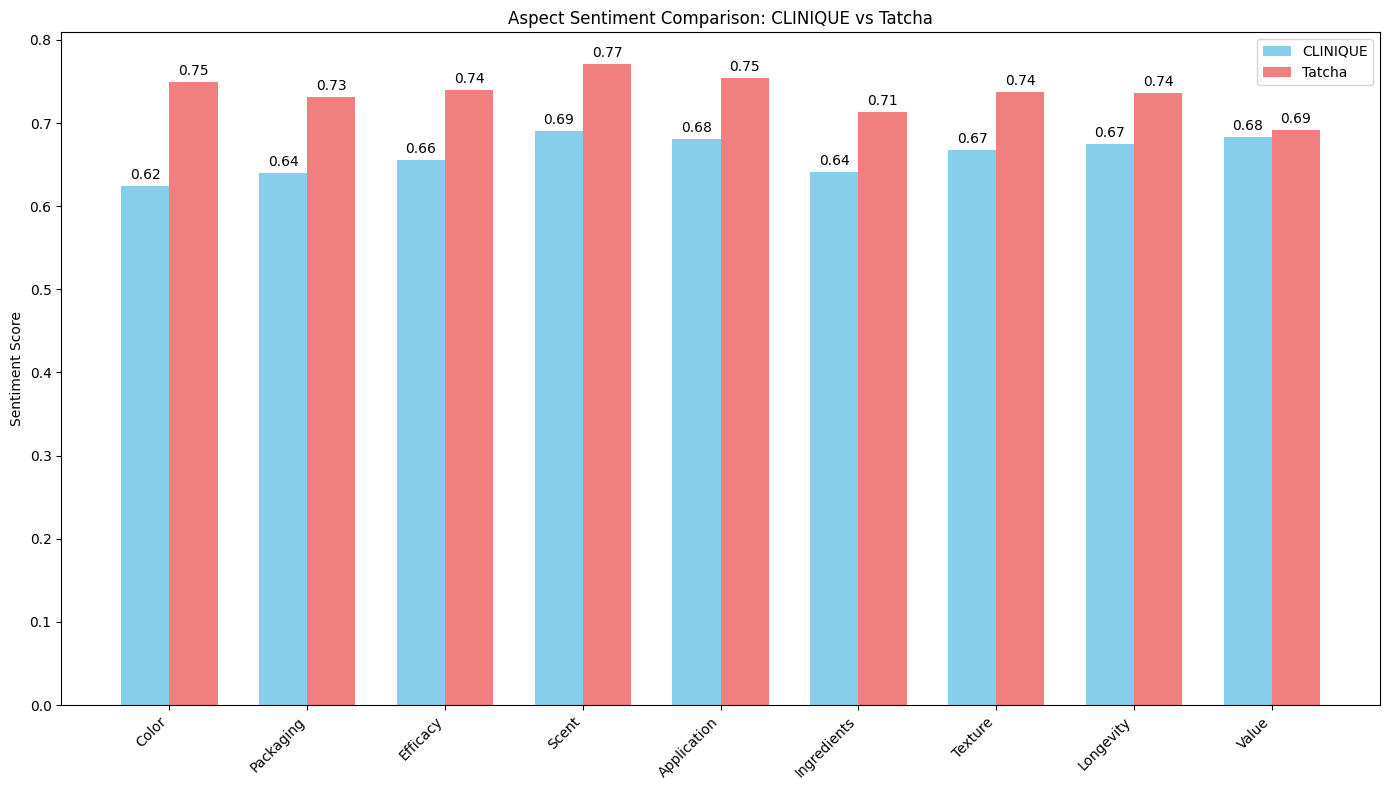


Key Insights:
- Color: Tatcha outperforms CLINIQUE by 0.13 sentiment points
- Packaging: Tatcha outperforms CLINIQUE by 0.09 sentiment points
- Efficacy: Tatcha outperforms CLINIQUE by 0.08 sentiment points

CASE STUDY 2: PRODUCT SENTIMENT DRIVERS
Analyzing sentiment drivers for LANEIGE - Lip Sleeping Mask Intense Hydration with Vitamin C
Total reviews: 16138


<Figure size 1400x1000 with 0 Axes>

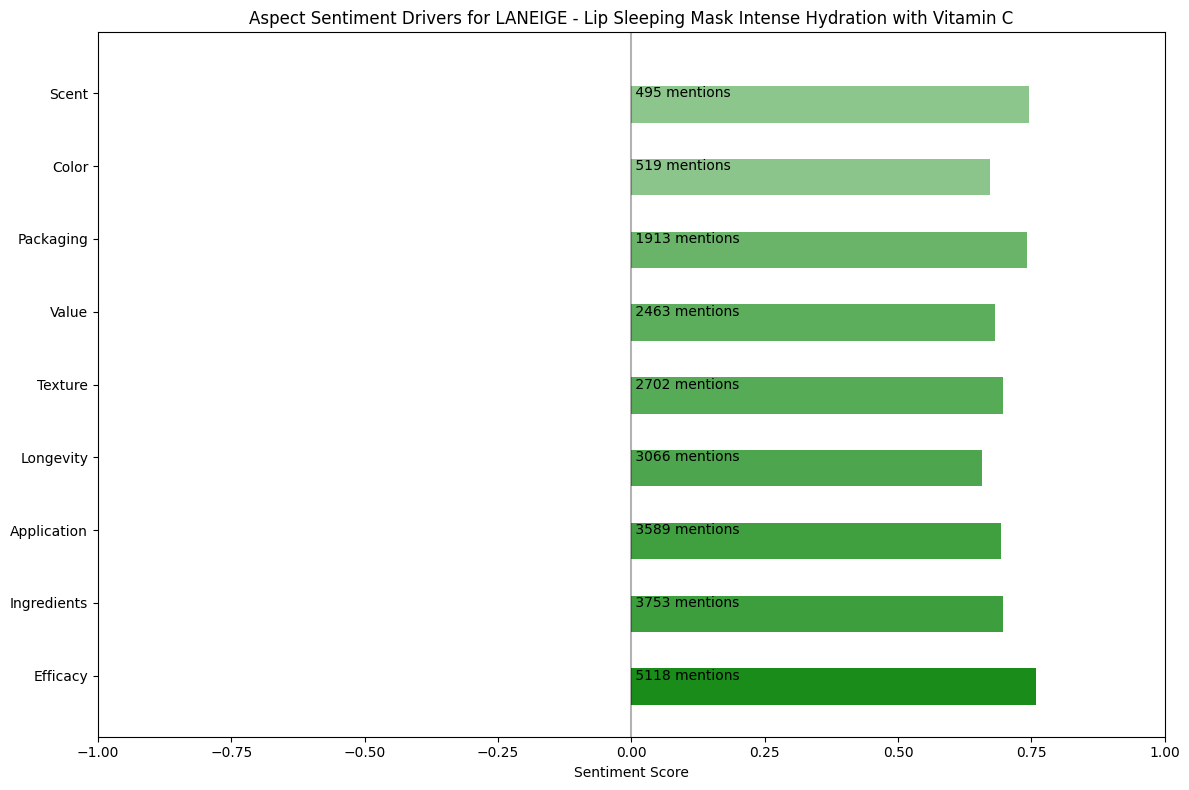


Key Insights:
Strengths:
- Scent: 0.76 sentiment, mentioned in 31.7% of reviews
- Color: 0.75 sentiment, mentioned in 3.1% of reviews

Improvement Areas:
- Efficacy: 0.66 sentiment, mentioned in 19.0% of reviews
- Ingredients: 0.67 sentiment, mentioned in 3.2% of reviews

Most Discussed Feature: Scent - mentioned in 31.7% of reviews

CASE STUDY 3: COMPETITIVE LANDSCAPE
Analyzing competitive landscape for aspect: texture


<Figure size 1400x800 with 0 Axes>

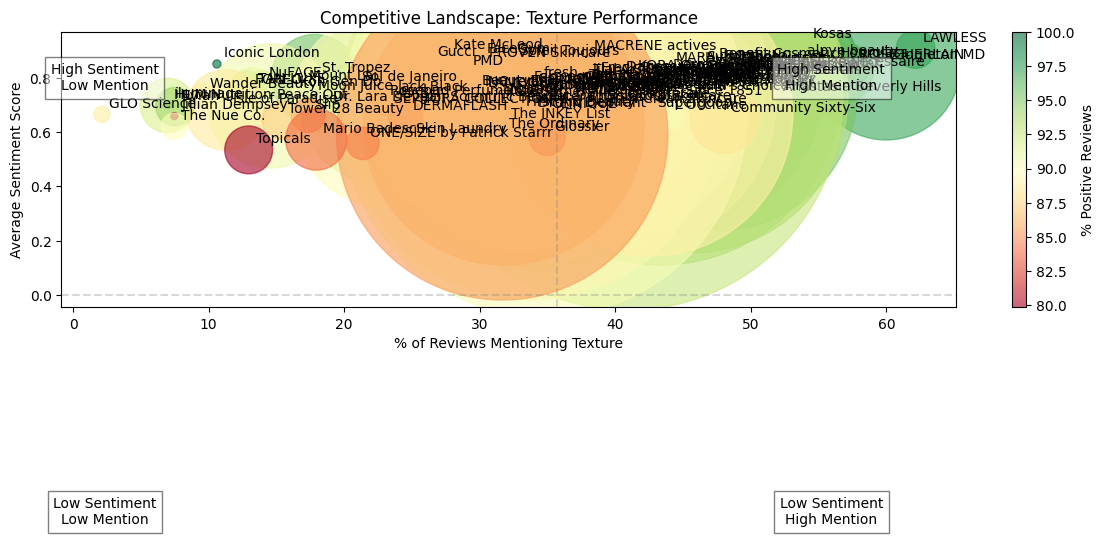


Key Insights:
Market Leader: Kosas leads in texture with 0.92 sentiment and 98.3% positive reviews
Most Discussed: Tatcha has the most texture mentions (19150) with 0.74 sentiment
Improvement Needed: Topicals has the lowest texture sentiment (0.53) among brands with significant mentions


{'brand_comparison':         aspect  CLINIQUE_sentiment  CLINIQUE_mentions  CLINIQUE_mention_pct  Tatcha_sentiment  Tatcha_mentions  Tatcha_mention_pct  sentiment_diff  abs_diff
 8        color            0.623798               3385              6.904077          0.749243             2680            5.730169       -0.125445  0.125445
 0    packaging            0.639962               4214              8.594913          0.731262             8371           17.898225       -0.091300  0.091300
 3     efficacy            0.655739              11988             24.450835          0.739928             9212           19.696387       -0.084189  0.084189
 2        scent            0.690198               5801             11.831773          0.770535             9914           21.197349       -0.080337  0.080337
 7  application            0.680441               9542             19.461951          0.754229             7632           16.318153       -0.073788  0.073788
 4  ingredients            0.641

In [95]:
# Example function to run all case studies
def run_absa_case_studies(merged_data):
    """
    Run all three case studies and generate comprehensive insights
    """
    print("=" * 50)
    print("CASE STUDY 1: BRAND COMPARISON")
    print("=" * 50)
    brand_comparison = case_study_1_brand_comparison(merged_data)
    
    print("\n" + "=" * 50)
    print("CASE STUDY 2: PRODUCT SENTIMENT DRIVERS")
    print("=" * 50)
    # Choose a popular product
    popular_product = merged_data['product_id'].value_counts().index[0]
    product_drivers = case_study_2_sentiment_drivers(merged_data, popular_product)
    
    print("\n" + "=" * 50)
    print("CASE STUDY 3: COMPETITIVE LANDSCAPE")
    print("=" * 50)
    # Choose a commonly discussed aspect
    aspect_counts = {aspect: merged_data[f'has_{aspect}'].sum() 
                    for aspect in beauty_aspects.keys()}
    top_aspect = max(aspect_counts.items(), key=lambda x: x[1])[0]
    competitive_landscape = case_study_3_competitive_landscape(merged_data, top_aspect)
    
    return {
        "brand_comparison": brand_comparison,
        "product_drivers": product_drivers,
        "competitive_landscape": competitive_landscape
    }
    
    


run_absa_case_studies(merged_data)